In [1]:
import numpy as np
import pandas as pd  
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler 
from sklearn.metrics import mean_squared_error, mean_absolute_error , mean_absolute_percentage_error
import matplotlib.pyplot as plt


Part 1

In [2]:
# Load dataset
train_df = pd.read_csv('/Users/hanyfaltaos/Downloads/Neuoral 24-25/train.csv')

# Check for missing values
print("Missing values per column:\n", train_df.isnull().sum())

# Handle missing values
if train_df.isnull().sum().sum() > 0:  # Check if there are any missing values
    # Fill missing values with column median
    train_df = train_df.fillna(train_df.median())
    print("Missing values handled by imputation (median substitution).")
else:
    print("No missing values found.")

# Define input (X) and target (y) features
input_features = ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']
X = train_df[input_features]
y = train_df['MedHouseVal']

# Normalize input features for neural network training
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)

# Normalize the target feature using MinMaxScaler
y_scaler = MinMaxScaler()
y_normalized = y_scaler.fit_transform(y.values.reshape(-1, 1))

# Split data into 80% for training/validation and 20% for testing
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X_normalized, y_normalized, test_size=0.2, random_state=42, shuffle=True
)

# Further split training/validation data into 75% training and 25% validation
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.25, random_state=42, shuffle=True
)

# Print the number of records in each set
print(f"Training Data: {len(X_train)} records")
print(f"Validation Data: {len(X_val)} records")
print(f"Testing Data: {len(X_test)} records")

print("Data preprocessing and splitting completed!")

Missing values per column:
 id             0
MedInc         0
HouseAge       0
AveRooms       0
AveBedrms      0
Population     0
AveOccup       0
Latitude       0
Longitude      0
MedHouseVal    0
dtype: int64
No missing values found.
Training Data: 22281 records
Validation Data: 7428 records
Testing Data: 7428 records
Data preprocessing and splitting completed!


Part 2

Epoch 1/50, Training Loss: 0.06552583047963635, Validation Loss: 0.06450653562271758
Epoch 2/50, Training Loss: 0.062074256370409836, Validation Loss: 0.06088770400152594
Epoch 3/50, Training Loss: 0.060010516928945386, Validation Loss: 0.05869903202672672
Epoch 4/50, Training Loss: 0.05881506695278021, Validation Loss: 0.05741200983254804
Epoch 5/50, Training Loss: 0.058222877233412934, Validation Loss: 0.05676279635942097
Epoch 6/50, Training Loss: 0.05783894028500495, Validation Loss: 0.0563328263244531
Epoch 7/50, Training Loss: 0.05761285096189376, Validation Loss: 0.05607258432028723
Epoch 8/50, Training Loss: 0.057475821368090936, Validation Loss: 0.05590938622692795
Epoch 9/50, Training Loss: 0.05738684209970134, Validation Loss: 0.05579856113617508
Epoch 10/50, Training Loss: 0.05734333541663877, Validation Loss: 0.055741341788705975
Epoch 11/50, Training Loss: 0.057318368597218165, Validation Loss: 0.055706616084046874
Epoch 12/50, Training Loss: 0.05730267954343278, Validati

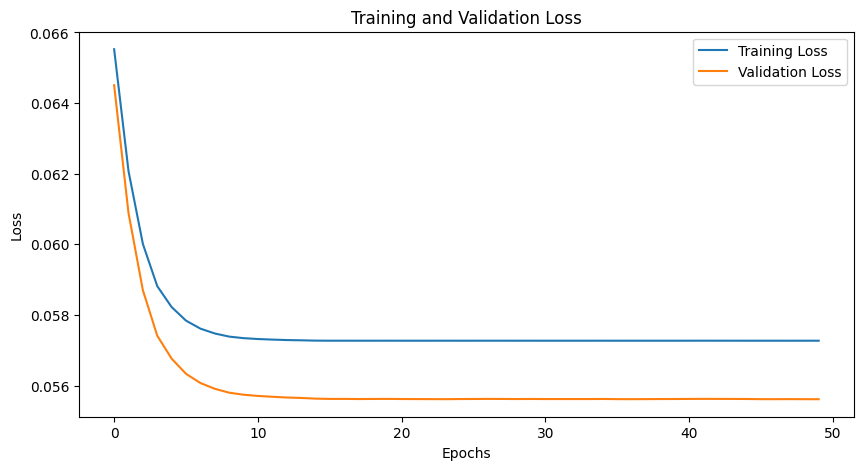

In [3]:
# Part 2: Neural Network Implementation from Scratch

class NeuralNet:
    def __init__(self, layers, epochs, learning_rate, momentum, activation='relu', val_split=0.2):
        self.L = len(layers)  # Number of layers
        self.n = layers  # Number of units in each layer
        self.epochs = epochs
        self.lr = learning_rate
        self.momentum = momentum
        self.activation_name = activation
        self.val_split = val_split

        # Initialize weights and thresholds using Xavier initialization
        self.w = [None] + [np.random.randn(self.n[l], self.n[l - 1]) * np.sqrt(2 / (self.n[l] + self.n[l - 1])) for l in range(1, self.L)]
        self.theta = [None] + [np.random.randn(self.n[l]) * np.sqrt(2 / self.n[l]) for l in range(1, self.L)]

        # Initialize previous weight changes for momentum
        self.d_w_prev = [None] + [np.zeros_like(self.w[l]) for l in range(1, self.L)]
        self.d_theta_prev = [None] + [np.zeros_like(self.theta[l]) for l in range(1, self.L)]

        # Initialize activations, fields, and deltas
        self.xi = [None] * self.L  # Array to hold activations for each layer
        self.h = [None] * self.L  # Array to hold the weighted sums before activation
        self.delta = [None] * self.L  # Array to hold error propagation terms for each layer

    def activation(self, x):
        if self.activation_name == 'sigmoid':
            return 1 / (1 + np.exp(-x))
        elif self.activation_name == 'relu':
            return np.maximum(0, x)
        elif self.activation_name == 'tanh':
            return np.tanh(x)
        elif self.activation_name == 'linear':
            return x

    def activation_derivative(self, x):
        if self.activation_name == 'sigmoid':
            return x * (1 - x)
        elif self.activation_name == 'relu':
            return np.where(x > 0, 1, 0)
        elif self.activation_name == 'tanh':
            return 1 - np.tanh(x) ** 2
        elif self.activation_name == 'linear':
            return np.ones_like(x)

    def feed_forward(self, x):
        x = np.array(x, dtype=float)  # Ensure input is a numpy array of floats
        self.xi[0] = x
        for l in range(1, self.L):
            self.h[l] = np.dot(self.w[l], self.xi[l - 1]) - self.theta[l]
            self.xi[l] = self.activation(self.h[l])
        return self.xi

    def back_propagate(self, y):
        # Calculate deltas and update weights/thresholds
        self.delta[-1] = self.activation_derivative(self.xi[-1]) * (self.xi[-1] - y)
        
        # Back-propagate delta to hidden layers
        for l in reversed(range(1, self.L - 1)):
            self.delta[l] = self.activation_derivative(self.xi[l]) * np.dot(self.w[l + 1].T, self.delta[l + 1])

        # Update weights and thresholds using deltas
        for l in range(1, self.L):
            d_w = -self.lr * np.outer(self.delta[l], self.xi[l - 1]) + self.momentum * self.d_w_prev[l]
            d_theta = self.lr * self.delta[l] + self.momentum * self.d_theta_prev[l]
            self.w[l] += d_w
            self.theta[l] += d_theta
            self.d_w_prev[l], self.d_theta_prev[l] = d_w, d_theta

    def fit(self, X, y, X_val=None, y_val=None):
        train_loss = []
        val_loss = []

        for epoch in range(self.epochs):
            for i in range(len(X)):
                # Choose a random pattern for online training
                idx = np.random.randint(0, len(X))
                x_mu, y_mu = np.array(X)[idx], np.array(y)[idx]

                # Feed-forward and back-propagate
                self.feed_forward(x_mu)
                self.back_propagate(y_mu)

            # Calculate training loss for the current epoch
            train_predictions = self.predict(np.array(X, dtype=float))
            train_loss.append(np.mean((train_predictions - np.array(y, dtype=float)) ** 2))

            # Calculate validation loss if validation data is provided
            if X_val is not None and y_val is not None:
                val_predictions = self.predict(np.array(X_val, dtype=float))
                val_loss.append(np.mean((val_predictions - np.array(y_val, dtype=float)) ** 2))

            # Print loss for each epoch to monitor training
            print(f"Epoch {epoch + 1}/{self.epochs}, Training Loss: {train_loss[-1]}, Validation Loss: {val_loss[-1] if val_loss else 'N/A'}")

        return train_loss, val_loss

    def predict(self, X):
        X = np.array(X, dtype=float)  # Ensure input is a numpy array of floats
        predictions = []
        for x in X:
            self.feed_forward(x)
            predictions.append(self.xi[-1])
        return np.array(predictions)

    def loss_epochs(self, X_train, y_train, X_val, y_val):
        train_loss = []
        val_loss = []
        for epoch in range(self.epochs):
            train_predictions = self.predict(X_train)
            val_predictions = self.predict(X_val)

            train_loss.append(np.mean((train_predictions - y_train) ** 2))
            val_loss.append(np.mean((val_predictions - y_val) ** 2))
        return train_loss, val_loss

# Plotting Training and Validation Loss
def plot_loss(train_loss, val_loss):
    plt.figure(figsize=(10, 5))
    plt.plot(train_loss, label='Training Loss')
    if val_loss:
        plt.plot(val_loss, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.show()

# Normalize Input Features for Training, Validation, and Testing
X_train_scaled = (X_train - X_train.min()) / (X_train.max() - X_train.min())
X_val_scaled = (X_val - X_val.min()) / (X_val.max() - X_val.min())
X_test_scaled = (X_test - X_test.min()) / (X_test.max() - X_test.min())

# Initialize and Train the Neural Network
nn_test = NeuralNet(
    layers=[8, 9, 5, 1],  # Architecture: 8 input features, 2 hidden layers, 1 output
    epochs=50,  # Number of epochs
    learning_rate=0.00001,  # Learning rate
    momentum=0.9,  # Momentum term
    activation='sigmoid',  # Activation function
    val_split=0.2  # Validation split is handled externally
)

train_loss, val_loss = nn_test.fit(
    X_train_scaled, y_train, X_val_scaled, y_val
)

# Evaluate on Test Data
test_predictions = nn_test.predict(X_test_scaled)
test_loss = np.mean((test_predictions - y_test) ** 2)
print(f"Test Loss: {test_loss}")

# Plot Training and Validation Loss
plot_loss(train_loss, val_loss)


Part 3.1

Evaluating Set 1 - Layers: [8, 9, 1], Learning Rate: 0.0001, Momentum: 0.5, Activation: sigmoid
Epoch 1/50, Training Loss: 0.05792112761012, Validation Loss: 0.06093292361303586
Epoch 2/50, Training Loss: 0.05705436913449432, Validation Loss: 0.059906397565817573
Epoch 3/50, Training Loss: 0.05673204682777272, Validation Loss: 0.059474852861774875
Epoch 4/50, Training Loss: 0.056648442387033274, Validation Loss: 0.059331351038381754
Epoch 5/50, Training Loss: 0.056637321566657045, Validation Loss: 0.0593043506500453
Epoch 6/50, Training Loss: 0.05663289158834974, Validation Loss: 0.0592904661265031
Epoch 7/50, Training Loss: 0.0566301106563694, Validation Loss: 0.05927826475081996
Epoch 8/50, Training Loss: 0.056631062465880885, Validation Loss: 0.05928327339881683
Epoch 9/50, Training Loss: 0.056629343292301494, Validation Loss: 0.05927325792765555
Epoch 10/50, Training Loss: 0.056629052367643574, Validation Loss: 0.05927048889408899
Epoch 11/50, Training Loss: 0.05662885132650163, Va

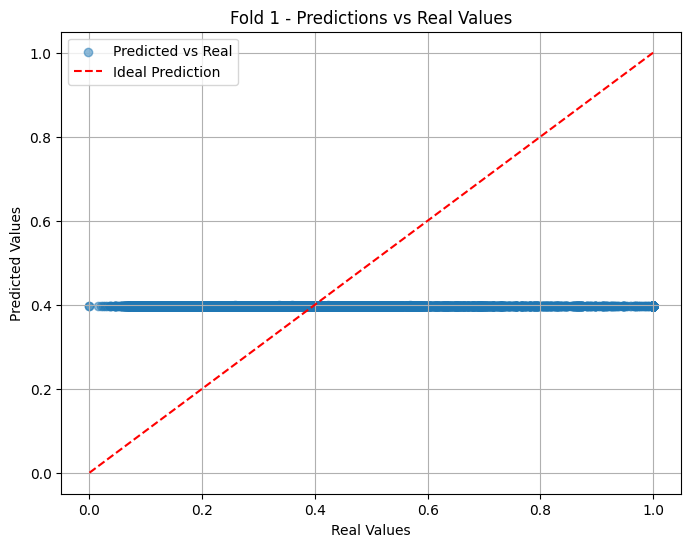

Epoch 1/50, Training Loss: 0.06261914945484803, Validation Loss: 0.06209085561633552
Epoch 2/50, Training Loss: 0.058742536975692664, Validation Loss: 0.057932957170308254
Epoch 3/50, Training Loss: 0.05775785848989622, Validation Loss: 0.056797881357336294
Epoch 4/50, Training Loss: 0.05760770496204513, Validation Loss: 0.05660160524866429
Epoch 5/50, Training Loss: 0.05754358128646733, Validation Loss: 0.05650416859737965
Epoch 6/50, Training Loss: 0.05752562582589985, Validation Loss: 0.056469813356523145
Epoch 7/50, Training Loss: 0.057519205787896044, Validation Loss: 0.05645367443813248
Epoch 8/50, Training Loss: 0.057515825838181, Validation Loss: 0.05643968549764216
Epoch 9/50, Training Loss: 0.05751572840617948, Validation Loss: 0.056439548494697636
Epoch 10/50, Training Loss: 0.05752047197192314, Validation Loss: 0.0564578379658405
Epoch 11/50, Training Loss: 0.05751531750828603, Validation Loss: 0.05643659646215635
Epoch 12/50, Training Loss: 0.05751529470312332, Validation 

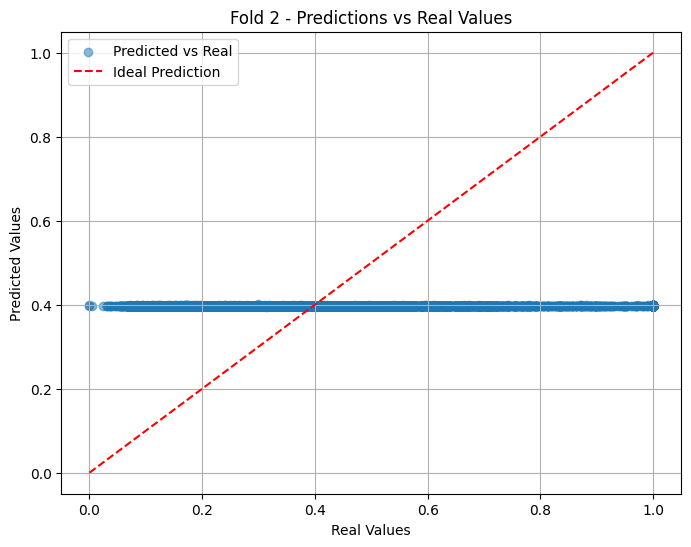

Epoch 1/50, Training Loss: 0.09938928144512027, Validation Loss: 0.09699176133401927
Epoch 2/50, Training Loss: 0.07781064854858831, Validation Loss: 0.07575806946648637
Epoch 3/50, Training Loss: 0.06516133475770422, Validation Loss: 0.06341441036589651
Epoch 4/50, Training Loss: 0.05988485658214151, Validation Loss: 0.058354052162738
Epoch 5/50, Training Loss: 0.058238741217234435, Validation Loss: 0.05683078571901783
Epoch 6/50, Training Loss: 0.057707599093474976, Validation Loss: 0.05637644279750376
Epoch 7/50, Training Loss: 0.05759645560221476, Validation Loss: 0.056298515911740385
Epoch 8/50, Training Loss: 0.05756625333285186, Validation Loss: 0.056286182340870294
Epoch 9/50, Training Loss: 0.05756154921673707, Validation Loss: 0.05628633948853226
Epoch 10/50, Training Loss: 0.05755734191370868, Validation Loss: 0.05628969975925847
Epoch 11/50, Training Loss: 0.05755659067398561, Validation Loss: 0.05629445190411093
Epoch 12/50, Training Loss: 0.057556865234443234, Validation 

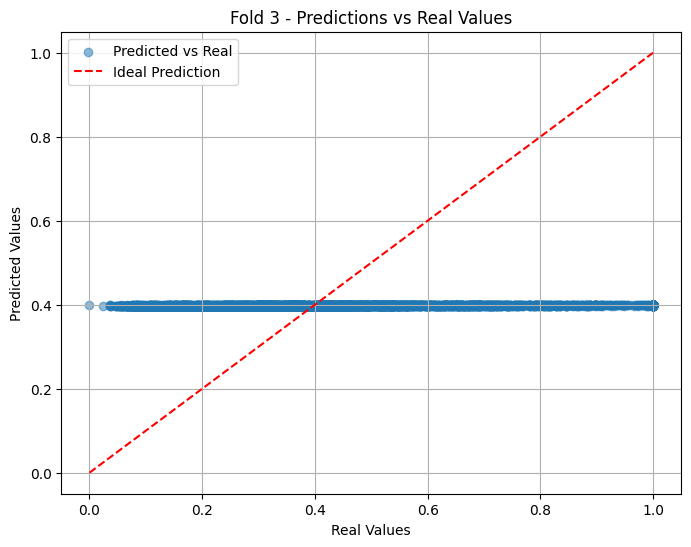

Epoch 1/50, Training Loss: 0.07398040517169664, Validation Loss: 0.07409725487495993
Epoch 2/50, Training Loss: 0.0632312059494494, Validation Loss: 0.06319472329432912
Epoch 3/50, Training Loss: 0.058921353503378675, Validation Loss: 0.058776839070480466
Epoch 4/50, Training Loss: 0.057774190946314745, Validation Loss: 0.05757523489857728
Epoch 5/50, Training Loss: 0.057452891284976194, Validation Loss: 0.057226047174169216
Epoch 6/50, Training Loss: 0.057380884928679946, Validation Loss: 0.05714391415147163
Epoch 7/50, Training Loss: 0.05732142182196744, Validation Loss: 0.057070762860442784
Epoch 8/50, Training Loss: 0.05730908260774265, Validation Loss: 0.057052443835741144
Epoch 9/50, Training Loss: 0.057305337756713655, Validation Loss: 0.05704441075715257
Epoch 10/50, Training Loss: 0.05730550648529704, Validation Loss: 0.057040935875025185
Epoch 11/50, Training Loss: 0.057305287894464714, Validation Loss: 0.057044437559865914
Epoch 12/50, Training Loss: 0.05730512516973572, Val

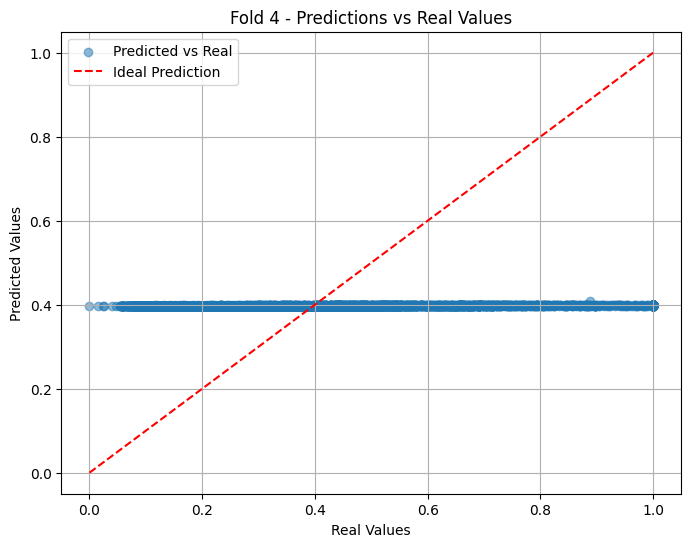

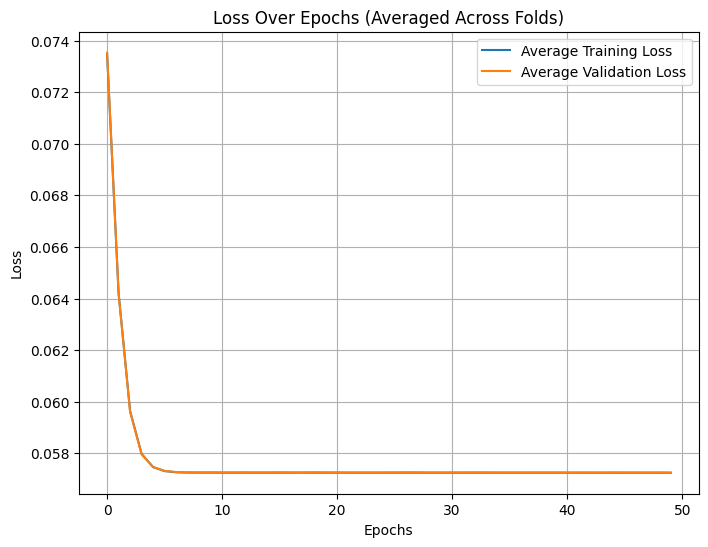

Set 1 Results - MSE: 0.0573, MAE: 0.1895, MAPE: 75.7607
Evaluating Set 2 - Layers: [8, 12, 1], Learning Rate: 0.01, Momentum: 0.9, Activation: relu
Epoch 1/50, Training Loss: 0.05891159434094439, Validation Loss: 0.06096490604854585
Epoch 2/50, Training Loss: 0.05558938908171294, Validation Loss: 0.057955382169187546
Epoch 3/50, Training Loss: 0.05339787492111168, Validation Loss: 0.056304287516611186
Epoch 4/50, Training Loss: 0.048843248090784656, Validation Loss: 0.05121331381008336
Epoch 5/50, Training Loss: 0.052914246326431734, Validation Loss: 0.0561576090323088
Epoch 6/50, Training Loss: 0.0904994118818562, Validation Loss: 0.09533748997459479
Epoch 7/50, Training Loss: 0.061233891724690515, Validation Loss: 0.06458973211267617
Epoch 8/50, Training Loss: 0.0633802728071771, Validation Loss: 0.06686592163504376
Epoch 9/50, Training Loss: 0.05510217849339817, Validation Loss: 0.05757011514514804
Epoch 10/50, Training Loss: 0.061327454176594375, Validation Loss: 0.0628939219029410

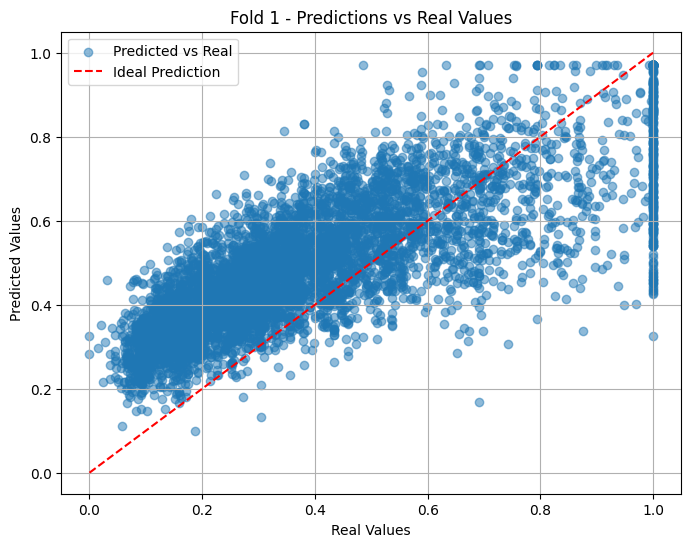

Epoch 1/50, Training Loss: 0.2164758905139149, Validation Loss: 0.21231344908335828
Epoch 2/50, Training Loss: 0.2164758905139149, Validation Loss: 0.21231344908335828
Epoch 3/50, Training Loss: 0.2164758905139149, Validation Loss: 0.21231344908335828
Epoch 4/50, Training Loss: 0.2164758905139149, Validation Loss: 0.21231344908335828
Epoch 5/50, Training Loss: 0.2164758905139149, Validation Loss: 0.21231344908335828
Epoch 6/50, Training Loss: 0.2164758905139149, Validation Loss: 0.21231344908335828
Epoch 7/50, Training Loss: 0.2164758905139149, Validation Loss: 0.21231344908335828
Epoch 8/50, Training Loss: 0.2164758905139149, Validation Loss: 0.21231344908335828
Epoch 9/50, Training Loss: 0.2164758905139149, Validation Loss: 0.21231344908335828
Epoch 10/50, Training Loss: 0.2164758905139149, Validation Loss: 0.21231344908335828
Epoch 11/50, Training Loss: 0.2164758905139149, Validation Loss: 0.21231344908335828
Epoch 12/50, Training Loss: 0.2164758905139149, Validation Loss: 0.2123134

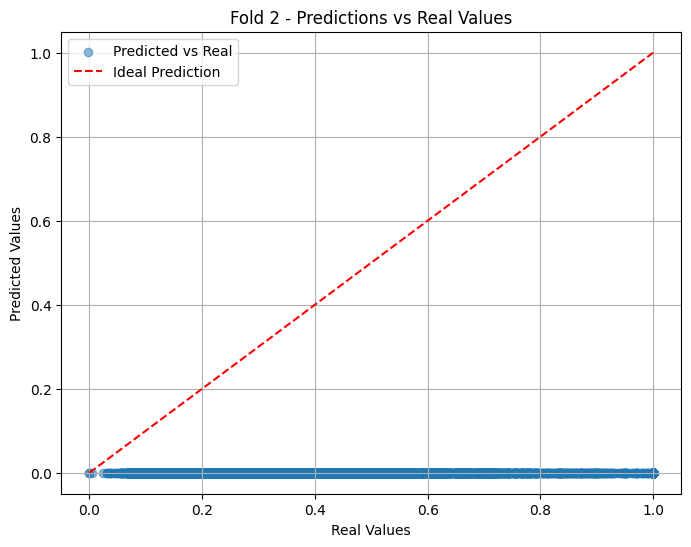

Epoch 1/50, Training Loss: 0.21630391127202583, Validation Loss: 0.21282941768501148
Epoch 2/50, Training Loss: 0.21630391127202583, Validation Loss: 0.21282941768501148
Epoch 3/50, Training Loss: 0.21630391127202583, Validation Loss: 0.21282941768501148
Epoch 4/50, Training Loss: 0.21630391127202583, Validation Loss: 0.21282941768501148
Epoch 5/50, Training Loss: 0.21630391127202583, Validation Loss: 0.21282941768501148
Epoch 6/50, Training Loss: 0.21630391127202583, Validation Loss: 0.21282941768501148
Epoch 7/50, Training Loss: 0.21630391127202583, Validation Loss: 0.21282941768501148
Epoch 8/50, Training Loss: 0.21630391127202583, Validation Loss: 0.21282941768501148
Epoch 9/50, Training Loss: 0.21630391127202583, Validation Loss: 0.21282941768501148
Epoch 10/50, Training Loss: 0.21630391127202583, Validation Loss: 0.21282941768501148
Epoch 11/50, Training Loss: 0.21630391127202583, Validation Loss: 0.21282941768501148
Epoch 12/50, Training Loss: 0.21630391127202583, Validation Los

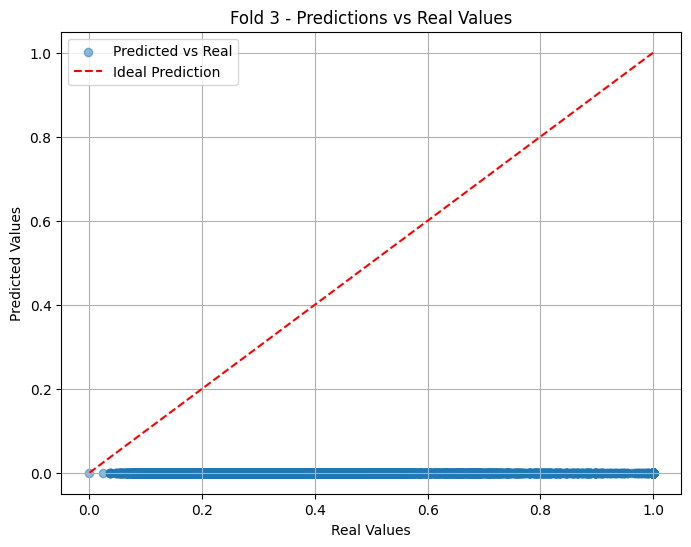

Epoch 1/50, Training Loss: 0.2152083192625305, Validation Loss: 0.21611639040865185
Epoch 2/50, Training Loss: 0.2152083192625305, Validation Loss: 0.21611639040865185
Epoch 3/50, Training Loss: 0.2152083192625305, Validation Loss: 0.21611639040865185
Epoch 4/50, Training Loss: 0.2152083192625305, Validation Loss: 0.21611639040865185
Epoch 5/50, Training Loss: 0.2152083192625305, Validation Loss: 0.21611639040865185
Epoch 6/50, Training Loss: 0.2152083192625305, Validation Loss: 0.21611639040865185
Epoch 7/50, Training Loss: 0.2152083192625305, Validation Loss: 0.21611639040865185
Epoch 8/50, Training Loss: 0.2152083192625305, Validation Loss: 0.21611639040865185
Epoch 9/50, Training Loss: 0.2152083192625305, Validation Loss: 0.21611639040865185
Epoch 10/50, Training Loss: 0.2152083192625305, Validation Loss: 0.21611639040865185
Epoch 11/50, Training Loss: 0.2152083192625305, Validation Loss: 0.21611639040865185
Epoch 12/50, Training Loss: 0.2152083192625305, Validation Loss: 0.2161163

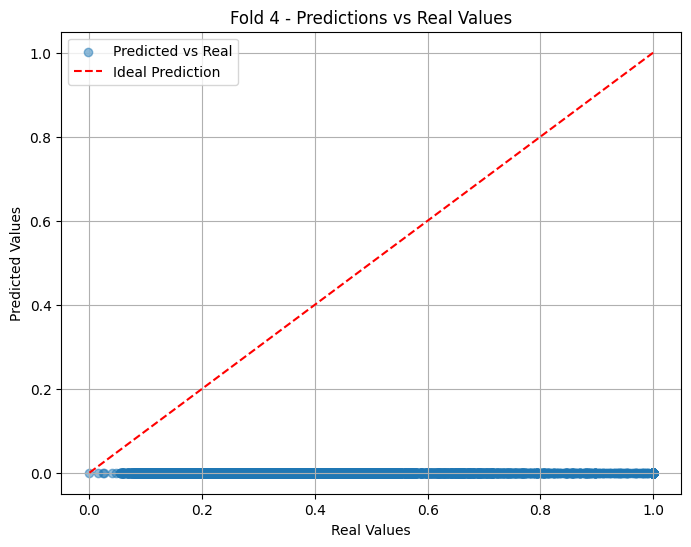

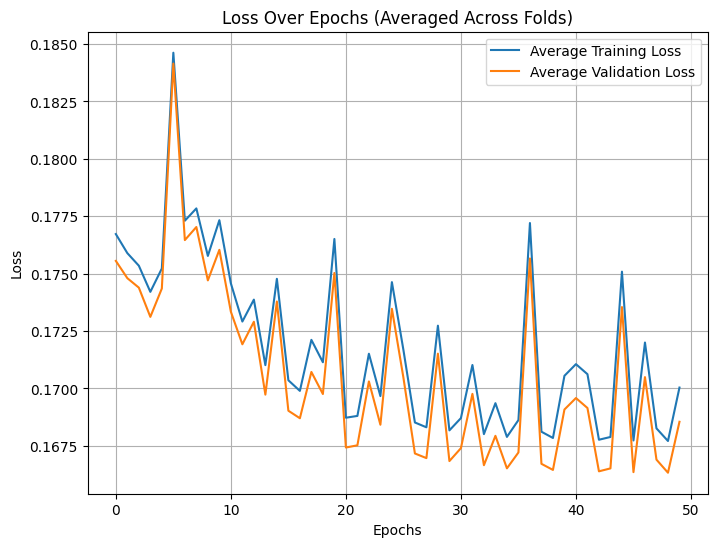

Set 2 Results - MSE: 0.1685, MAE: 0.3360, MAPE: 91.3400
Evaluating Set 3 - Layers: [8, 10, 5, 1], Learning Rate: 0.01, Momentum: 0.9, Activation: tanh
Epoch 1/50, Training Loss: 0.061414359798488284, Validation Loss: 0.06479064574421549
Epoch 2/50, Training Loss: 0.05618402929609609, Validation Loss: 0.058909566101794854
Epoch 3/50, Training Loss: 0.07319937829930961, Validation Loss: 0.07442871819686063
Epoch 4/50, Training Loss: 0.05504005331599599, Validation Loss: 0.05802543387135134
Epoch 5/50, Training Loss: 0.049005613472267985, Validation Loss: 0.051615935507823986
Epoch 6/50, Training Loss: 0.04446292211966783, Validation Loss: 0.04640006105857069
Epoch 7/50, Training Loss: 0.04171065940398195, Validation Loss: 0.043814726027179084
Epoch 8/50, Training Loss: 0.03680225468650718, Validation Loss: 0.03850141503115135
Epoch 9/50, Training Loss: 0.03605809154376563, Validation Loss: 0.03760730037222449
Epoch 10/50, Training Loss: 0.03859835119902639, Validation Loss: 0.03989809782

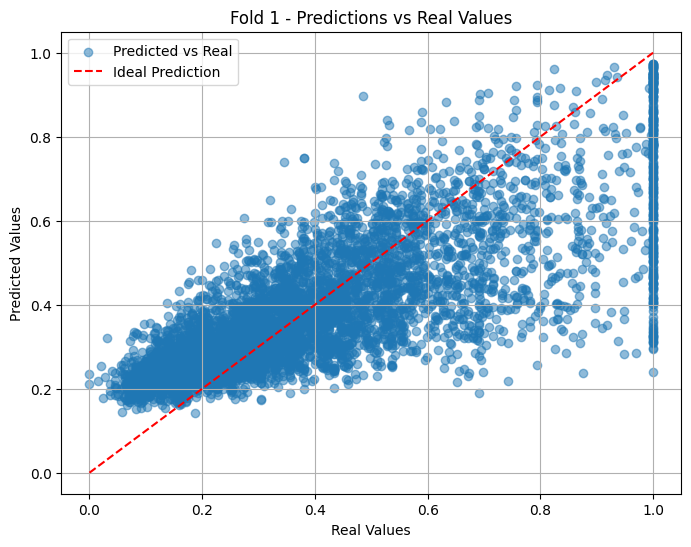

Epoch 1/50, Training Loss: 0.057800564148861845, Validation Loss: 0.05692080443659557
Epoch 2/50, Training Loss: 0.06049681067379428, Validation Loss: 0.059894186381911754
Epoch 3/50, Training Loss: 0.05799363283774434, Validation Loss: 0.05666558747875277
Epoch 4/50, Training Loss: 0.06116571587876941, Validation Loss: 0.06090524578774259
Epoch 5/50, Training Loss: 0.05316168025001776, Validation Loss: 0.052794665307336903
Epoch 6/50, Training Loss: 0.04907733698507459, Validation Loss: 0.04865674260962059
Epoch 7/50, Training Loss: 0.03514075214358059, Validation Loss: 0.0351700093049775
Epoch 8/50, Training Loss: 0.03286841355654371, Validation Loss: 0.03296375501408727
Epoch 9/50, Training Loss: 0.04281436088558694, Validation Loss: 0.04308313665249816
Epoch 10/50, Training Loss: 0.032760719041334235, Validation Loss: 0.03293484739076972
Epoch 11/50, Training Loss: 0.029520760022832222, Validation Loss: 0.02964597880581057
Epoch 12/50, Training Loss: 0.08125538899833788, Validation

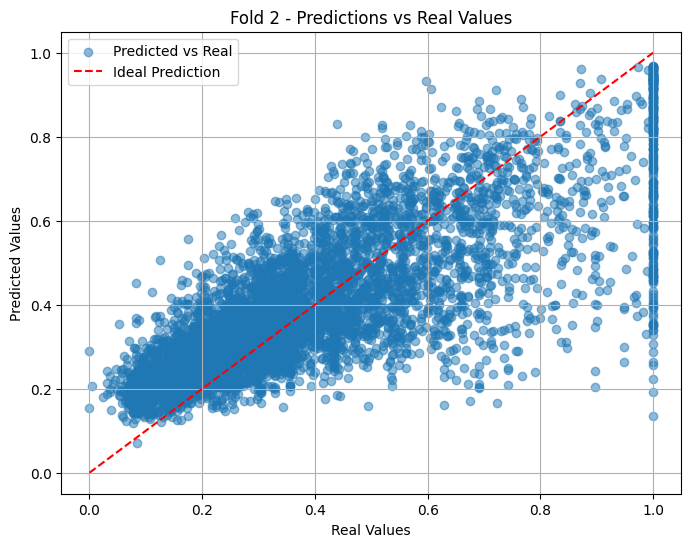

Epoch 1/50, Training Loss: 0.06169957204767181, Validation Loss: 0.06079466177432869
Epoch 2/50, Training Loss: 0.05808466865413034, Validation Loss: 0.05663070986483757
Epoch 3/50, Training Loss: 0.05743475800679409, Validation Loss: 0.05595469555027451
Epoch 4/50, Training Loss: 0.058024151595663015, Validation Loss: 0.05699610212656564
Epoch 5/50, Training Loss: 0.05034508892837927, Validation Loss: 0.048973709620723414
Epoch 6/50, Training Loss: 0.04487846572915628, Validation Loss: 0.0434160385329797
Epoch 7/50, Training Loss: 0.041902392776730524, Validation Loss: 0.040367346251089065
Epoch 8/50, Training Loss: 0.05061628766952392, Validation Loss: 0.04806031003207869
Epoch 9/50, Training Loss: 0.034364740114256116, Validation Loss: 0.032526771465328695
Epoch 10/50, Training Loss: 0.03456904810727842, Validation Loss: 0.03322900212723192
Epoch 11/50, Training Loss: 0.03859694090681945, Validation Loss: 0.037545836747828056
Epoch 12/50, Training Loss: 0.03377849380232071, Validati

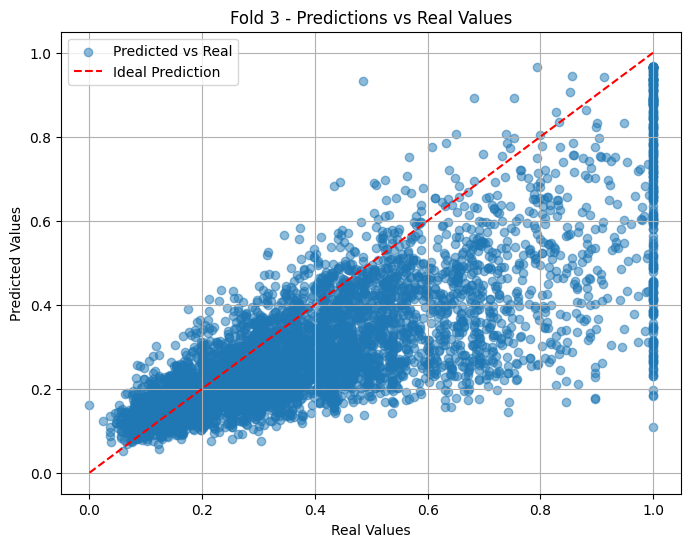

Epoch 1/50, Training Loss: 0.056873388472027026, Validation Loss: 0.05662032716598935
Epoch 2/50, Training Loss: 0.05641579275748477, Validation Loss: 0.05609755882553106
Epoch 3/50, Training Loss: 0.058134109587520424, Validation Loss: 0.05801460774623737
Epoch 4/50, Training Loss: 0.05561312721425594, Validation Loss: 0.0551838183624426
Epoch 5/50, Training Loss: 0.06098116614915809, Validation Loss: 0.060508416429564595
Epoch 6/50, Training Loss: 0.04157463264273027, Validation Loss: 0.041321883760251595
Epoch 7/50, Training Loss: 0.04254107498906541, Validation Loss: 0.042374425339265887
Epoch 8/50, Training Loss: 0.05674303291261507, Validation Loss: 0.056458803867307256
Epoch 9/50, Training Loss: 0.03422345868992046, Validation Loss: 0.033934160807355396
Epoch 10/50, Training Loss: 0.033810177253069465, Validation Loss: 0.03362524685695066
Epoch 11/50, Training Loss: 0.04896012464723967, Validation Loss: 0.04871689819194632
Epoch 12/50, Training Loss: 0.03652582049590671, Validat

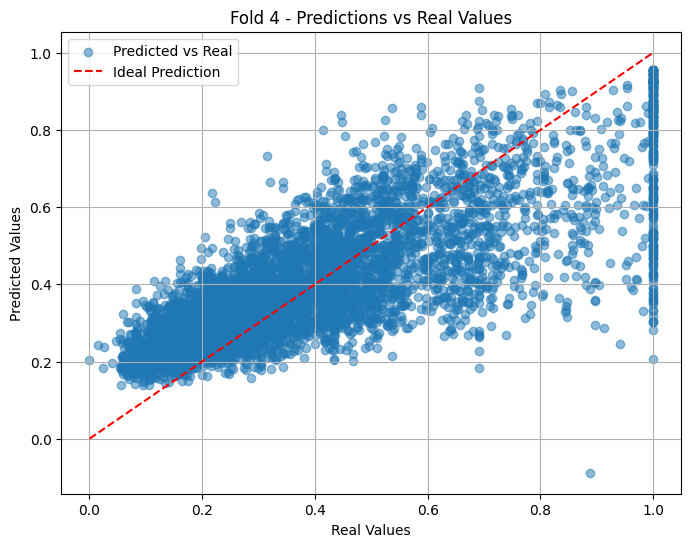

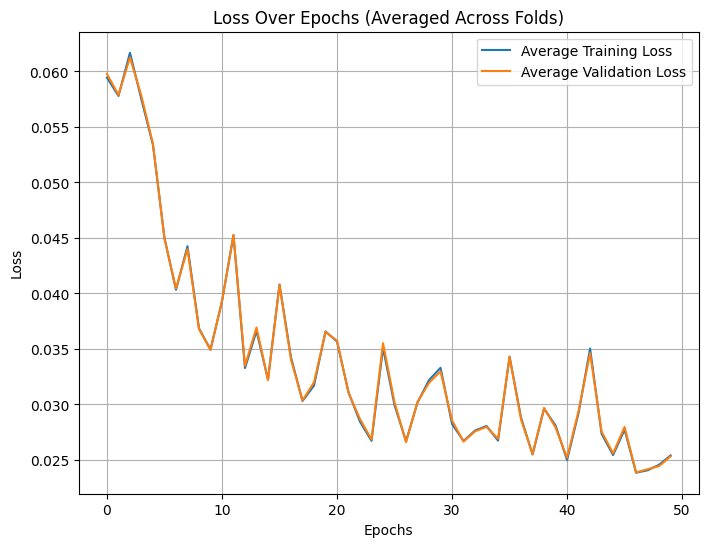

Set 3 Results - MSE: 0.0253, MAE: 0.1152, MAPE: 36.9301
Evaluating Set 4 - Layers: [8, 16, 8, 1], Learning Rate: 0.01, Momentum: 0.9, Activation: relu
Epoch 1/50, Training Loss: 0.05662466673425346, Validation Loss: 0.05930810712649011
Epoch 2/50, Training Loss: 0.06786553773874948, Validation Loss: 0.06939459588120209
Epoch 3/50, Training Loss: 0.05886199227561428, Validation Loss: 0.06199316260646228
Epoch 4/50, Training Loss: 0.05680757016693373, Validation Loss: 0.05961404204570566
Epoch 5/50, Training Loss: 0.05707170817249297, Validation Loss: 0.05996776392749954
Epoch 6/50, Training Loss: 0.0569590548094801, Validation Loss: 0.05940498189081268
Epoch 7/50, Training Loss: 0.05662341291270269, Validation Loss: 0.05926636302964517
Epoch 8/50, Training Loss: 0.05816723988549546, Validation Loss: 0.06039482553705029
Epoch 9/50, Training Loss: 0.059860203077286456, Validation Loss: 0.061888053936376905
Epoch 10/50, Training Loss: 0.055707227337762046, Validation Loss: 0.05837877822549

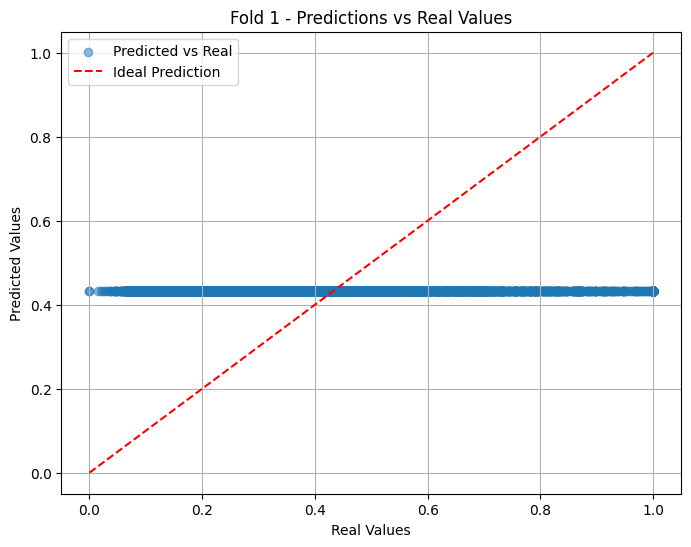

Epoch 1/50, Training Loss: 0.2164758905139149, Validation Loss: 0.21231344908335828
Epoch 2/50, Training Loss: 0.2164758905139149, Validation Loss: 0.21231344908335828
Epoch 3/50, Training Loss: 0.2164758905139149, Validation Loss: 0.21231344908335828
Epoch 4/50, Training Loss: 0.2164758905139149, Validation Loss: 0.21231344908335828
Epoch 5/50, Training Loss: 0.2164758905139149, Validation Loss: 0.21231344908335828
Epoch 6/50, Training Loss: 0.2164758905139149, Validation Loss: 0.21231344908335828
Epoch 7/50, Training Loss: 0.2164758905139149, Validation Loss: 0.21231344908335828
Epoch 8/50, Training Loss: 0.2164758905139149, Validation Loss: 0.21231344908335828
Epoch 9/50, Training Loss: 0.2164758905139149, Validation Loss: 0.21231344908335828
Epoch 10/50, Training Loss: 0.2164758905139149, Validation Loss: 0.21231344908335828
Epoch 11/50, Training Loss: 0.2164758905139149, Validation Loss: 0.21231344908335828
Epoch 12/50, Training Loss: 0.2164758905139149, Validation Loss: 0.2123134

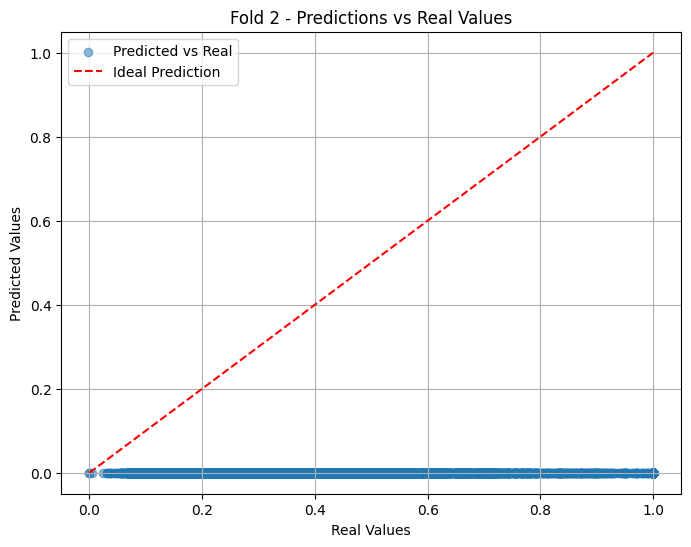

Epoch 1/50, Training Loss: 0.21630391127202583, Validation Loss: 0.21282941768501148
Epoch 2/50, Training Loss: 0.21630391127202583, Validation Loss: 0.21282941768501148
Epoch 3/50, Training Loss: 0.21630391127202583, Validation Loss: 0.21282941768501148
Epoch 4/50, Training Loss: 0.21630391127202583, Validation Loss: 0.21282941768501148
Epoch 5/50, Training Loss: 0.21630391127202583, Validation Loss: 0.21282941768501148
Epoch 6/50, Training Loss: 0.21630391127202583, Validation Loss: 0.21282941768501148
Epoch 7/50, Training Loss: 0.21630391127202583, Validation Loss: 0.21282941768501148
Epoch 8/50, Training Loss: 0.21630391127202583, Validation Loss: 0.21282941768501148
Epoch 9/50, Training Loss: 0.21630391127202583, Validation Loss: 0.21282941768501148
Epoch 10/50, Training Loss: 0.21630391127202583, Validation Loss: 0.21282941768501148
Epoch 11/50, Training Loss: 0.21630391127202583, Validation Loss: 0.21282941768501148
Epoch 12/50, Training Loss: 0.21630391127202583, Validation Los

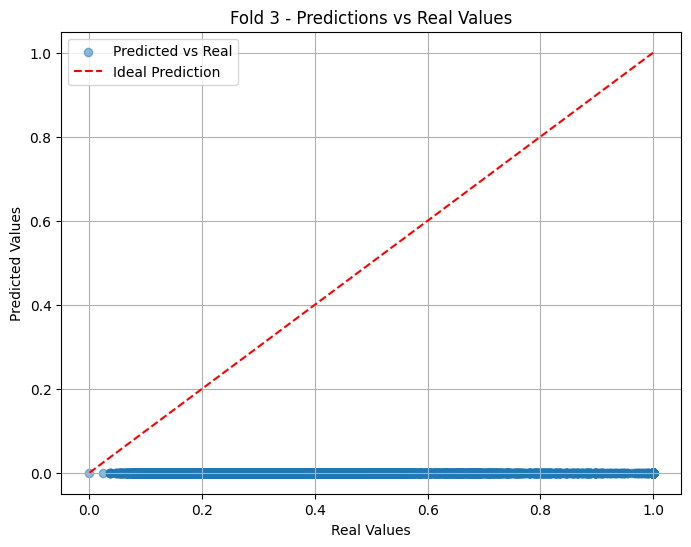

Epoch 1/50, Training Loss: 0.2152083192625305, Validation Loss: 0.21611639040865185
Epoch 2/50, Training Loss: 0.2152083192625305, Validation Loss: 0.21611639040865185
Epoch 3/50, Training Loss: 0.2152083192625305, Validation Loss: 0.21611639040865185
Epoch 4/50, Training Loss: 0.2152083192625305, Validation Loss: 0.21611639040865185
Epoch 5/50, Training Loss: 0.2152083192625305, Validation Loss: 0.21611639040865185
Epoch 6/50, Training Loss: 0.2152083192625305, Validation Loss: 0.21611639040865185
Epoch 7/50, Training Loss: 0.2152083192625305, Validation Loss: 0.21611639040865185
Epoch 8/50, Training Loss: 0.2152083192625305, Validation Loss: 0.21611639040865185
Epoch 9/50, Training Loss: 0.2152083192625305, Validation Loss: 0.21611639040865185
Epoch 10/50, Training Loss: 0.2152083192625305, Validation Loss: 0.21611639040865185
Epoch 11/50, Training Loss: 0.2152083192625305, Validation Loss: 0.21611639040865185
Epoch 12/50, Training Loss: 0.2152083192625305, Validation Loss: 0.2161163

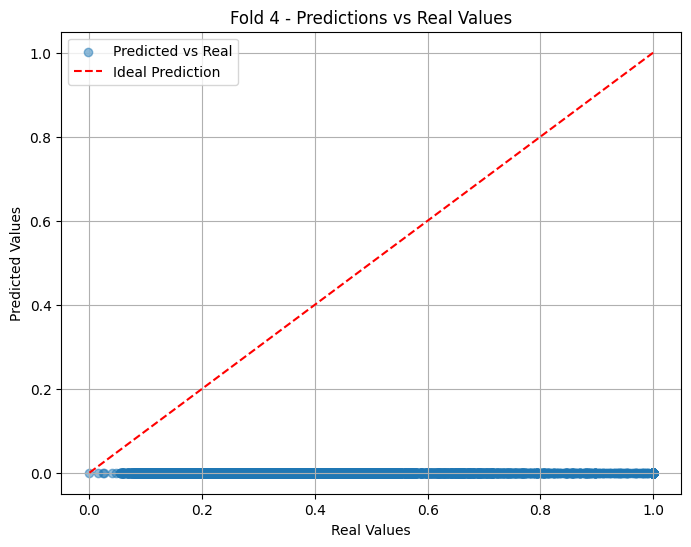

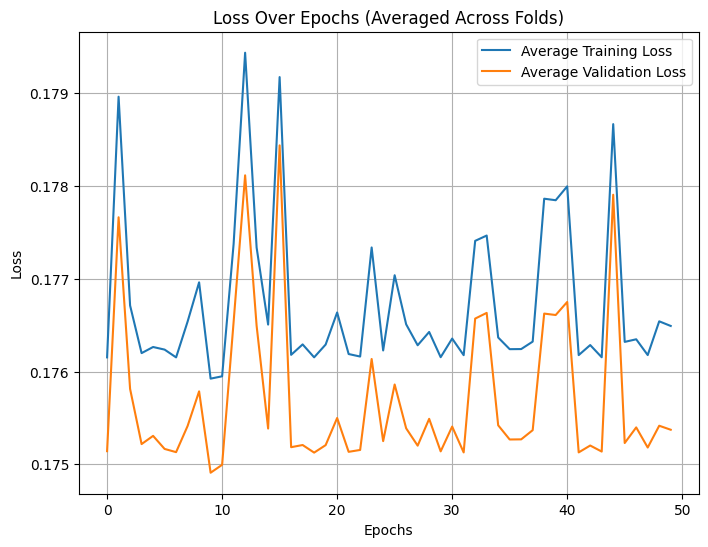

Set 4 Results - MSE: 0.1754, MAE: 0.3475, MAPE: 96.3208
Evaluating Set 5 - Layers: [8, 8, 8, 1], Learning Rate: 1e-05, Momentum: 0.6, Activation: sigmoid
Epoch 1/50, Training Loss: 0.058527023426873055, Validation Loss: 0.06071061951219844
Epoch 2/50, Training Loss: 0.05821723508077092, Validation Loss: 0.06043956512215355
Epoch 3/50, Training Loss: 0.05792461325765897, Validation Loss: 0.06018718787229171
Epoch 4/50, Training Loss: 0.05770232798339501, Validation Loss: 0.05999863124292826
Epoch 5/50, Training Loss: 0.057526641475976165, Validation Loss: 0.05985217172870787
Epoch 6/50, Training Loss: 0.05738952550394273, Validation Loss: 0.05973992565118457
Epoch 7/50, Training Loss: 0.05726182282529528, Validation Loss: 0.05963750113550013
Epoch 8/50, Training Loss: 0.057153893290947354, Validation Loss: 0.05955301627690101
Epoch 9/50, Training Loss: 0.057068026930907886, Validation Loss: 0.05948759554128279
Epoch 10/50, Training Loss: 0.056995606971888456, Validation Loss: 0.05943404

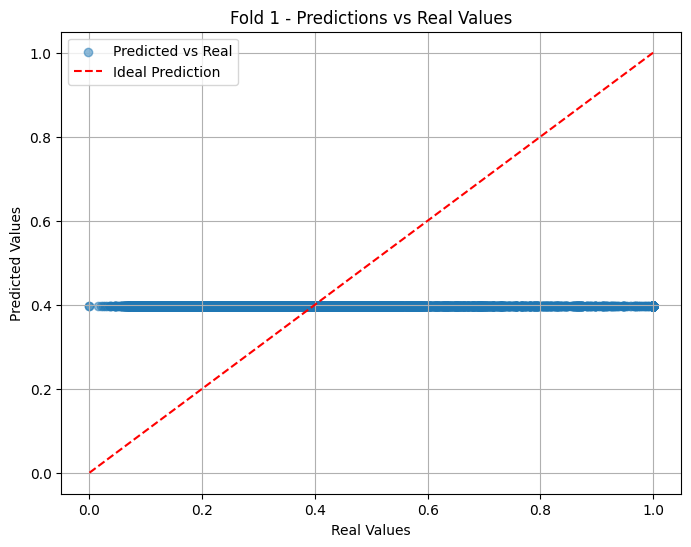

Epoch 1/50, Training Loss: 0.2025802926233493, Validation Loss: 0.20443172259507947
Epoch 2/50, Training Loss: 0.19267165619610374, Validation Loss: 0.19442091819533078
Epoch 3/50, Training Loss: 0.1827102400273277, Validation Loss: 0.18435293964271615
Epoch 4/50, Training Loss: 0.17278750041128968, Validation Loss: 0.17431974579056578
Epoch 5/50, Training Loss: 0.1630633150593959, Validation Loss: 0.16448259859724754
Epoch 6/50, Training Loss: 0.1535014006312376, Validation Loss: 0.1548044066972717
Epoch 7/50, Training Loss: 0.1442681071819198, Validation Loss: 0.145453190796762
Epoch 8/50, Training Loss: 0.1355150890393844, Validation Loss: 0.13658243116921617
Epoch 9/50, Training Loss: 0.12727635989655722, Validation Loss: 0.12822666977277758
Epoch 10/50, Training Loss: 0.11966212531590767, Validation Loss: 0.12049794888702112
Epoch 11/50, Training Loss: 0.11260677993128299, Validation Loss: 0.11333006751032994
Epoch 12/50, Training Loss: 0.10612782574052045, Validation Loss: 0.1067

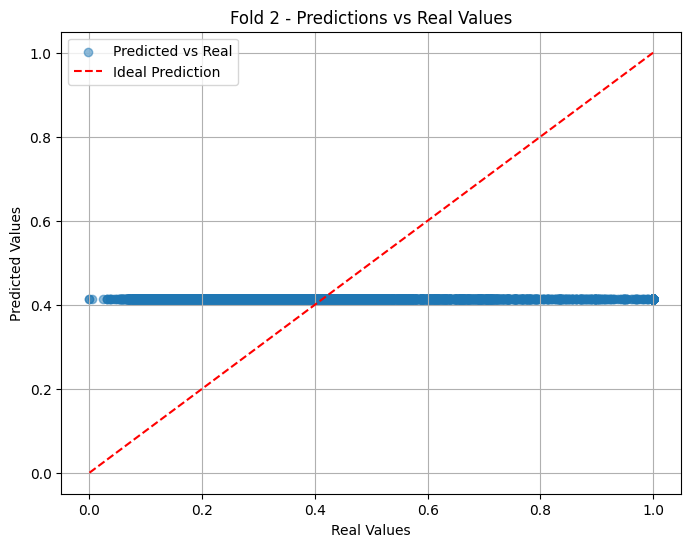

Epoch 1/50, Training Loss: 0.07494820852396969, Validation Loss: 0.07441695805325887
Epoch 2/50, Training Loss: 0.07212879958759952, Validation Loss: 0.07153550979847197
Epoch 3/50, Training Loss: 0.069755712660981, Validation Loss: 0.06910535511949063
Epoch 4/50, Training Loss: 0.06769736082545258, Validation Loss: 0.06699280171781148
Epoch 5/50, Training Loss: 0.06611331793074329, Validation Loss: 0.06536316163191781
Epoch 6/50, Training Loss: 0.06467575509646269, Validation Loss: 0.06388038582932422
Epoch 7/50, Training Loss: 0.06352745613968484, Validation Loss: 0.06269255500786962
Epoch 8/50, Training Loss: 0.06258388871328767, Validation Loss: 0.061713536424769025
Epoch 9/50, Training Loss: 0.061777385881549546, Validation Loss: 0.06087397251875283
Epoch 10/50, Training Loss: 0.061111803950591945, Validation Loss: 0.06017861975667982
Epoch 11/50, Training Loss: 0.0605566135690313, Validation Loss: 0.0595963651379294
Epoch 12/50, Training Loss: 0.06007437655508694, Validation Loss

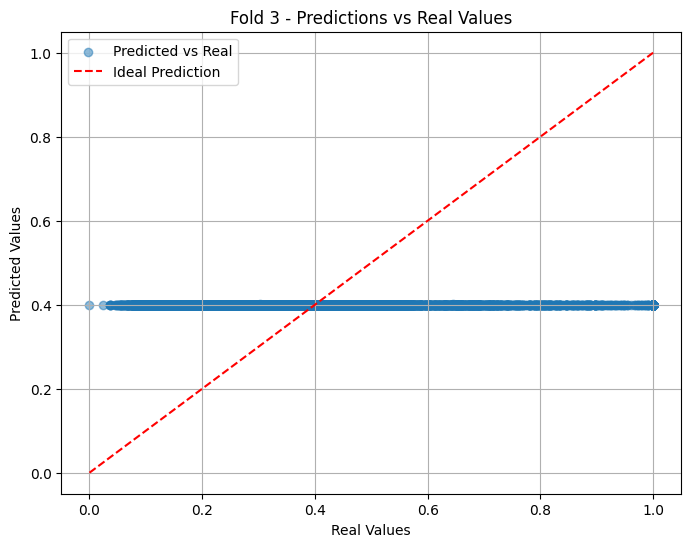

Epoch 1/50, Training Loss: 0.3214158822840593, Validation Loss: 0.3196469800877587
Epoch 2/50, Training Loss: 0.3162447993408672, Validation Loss: 0.31449074142561917
Epoch 3/50, Training Loss: 0.31064927684770094, Validation Loss: 0.30891144938722614
Epoch 4/50, Training Loss: 0.3045357395155189, Validation Loss: 0.3028158511486358
Epoch 5/50, Training Loss: 0.29795956030358645, Validation Loss: 0.29625921782058284
Epoch 6/50, Training Loss: 0.2908462591731839, Validation Loss: 0.28916736201136606
Epoch 7/50, Training Loss: 0.28303719827605195, Validation Loss: 0.2813822235490817
Epoch 8/50, Training Loss: 0.27466818055035064, Validation Loss: 0.27303930770503815
Epoch 9/50, Training Loss: 0.2655926617739734, Validation Loss: 0.26399266896493473
Epoch 10/50, Training Loss: 0.2558629452339012, Validation Loss: 0.2542946224616976
Epoch 11/50, Training Loss: 0.24542216555107818, Validation Loss: 0.24388870360514253
Epoch 12/50, Training Loss: 0.23433067017180878, Validation Loss: 0.23283

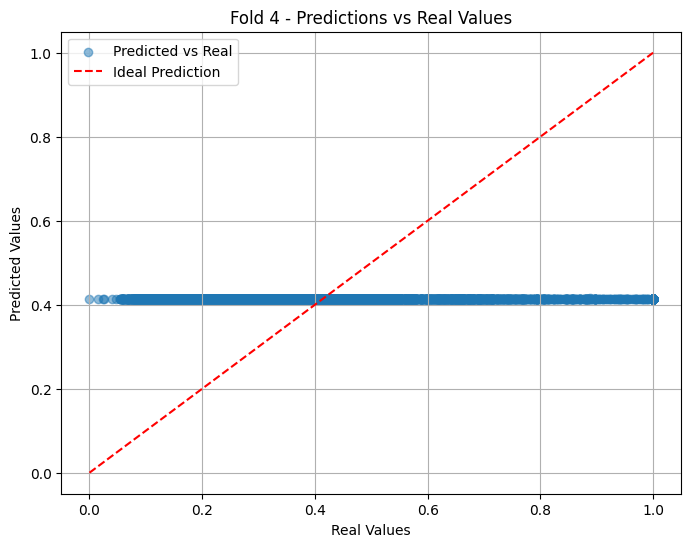

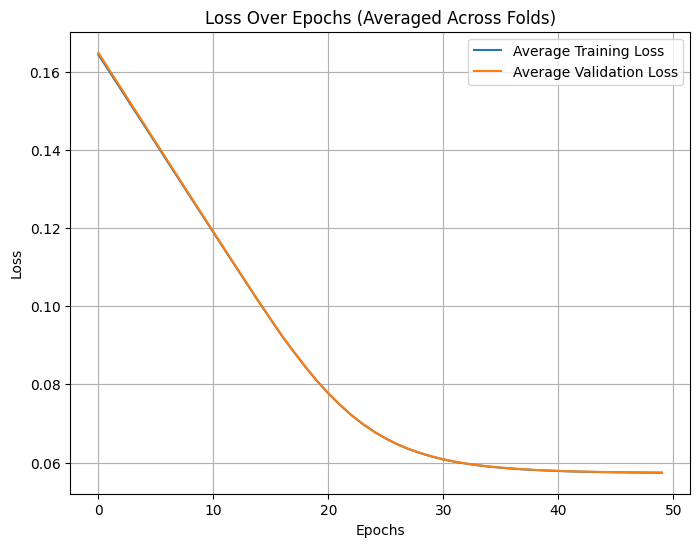

Set 5 Results - MSE: 0.0574, MAE: 0.1913, MAPE: 77.8221
Evaluating Set 6 - Layers: [8, 20, 15, 1], Learning Rate: 0.001, Momentum: 0.3, Activation: relu
Epoch 1/50, Training Loss: 0.05898780930072965, Validation Loss: 0.06213370322759118
Epoch 2/50, Training Loss: 0.05663279547538403, Validation Loss: 0.059287140143068684
Epoch 3/50, Training Loss: 0.056507172518547054, Validation Loss: 0.05911660858144072
Epoch 4/50, Training Loss: 0.056459290476608026, Validation Loss: 0.05920836212321335
Epoch 5/50, Training Loss: 0.05622354619484364, Validation Loss: 0.0588427328833246
Epoch 6/50, Training Loss: 0.05657281477257026, Validation Loss: 0.059435291822941286
Epoch 7/50, Training Loss: 0.056260976937866546, Validation Loss: 0.058711535628276294
Epoch 8/50, Training Loss: 0.05600678065996267, Validation Loss: 0.05877570827945981
Epoch 9/50, Training Loss: 0.055679048590636424, Validation Loss: 0.05830679780825023
Epoch 10/50, Training Loss: 0.056369660212950055, Validation Loss: 0.0586913

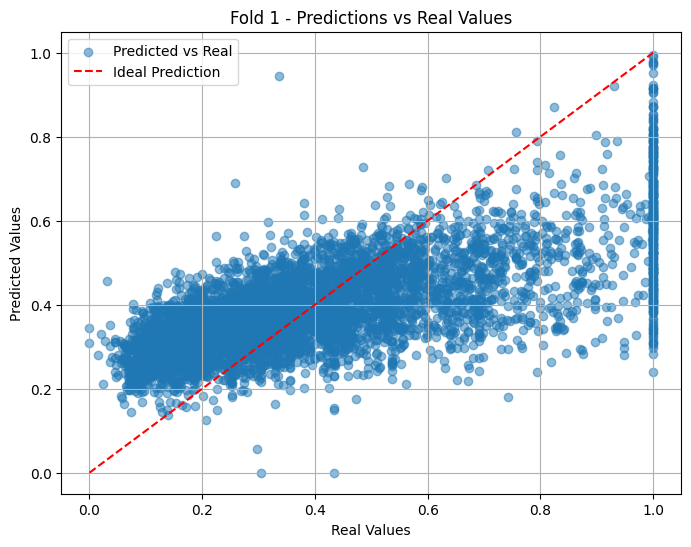

Epoch 1/50, Training Loss: 0.05773553135762307, Validation Loss: 0.056816179603837426
Epoch 2/50, Training Loss: 0.05740089706820292, Validation Loss: 0.05627450856372606
Epoch 3/50, Training Loss: 0.05731518022416853, Validation Loss: 0.05621545198287588
Epoch 4/50, Training Loss: 0.057285789964638664, Validation Loss: 0.056280655546549714
Epoch 5/50, Training Loss: 0.057455407356732366, Validation Loss: 0.056277999265793806
Epoch 6/50, Training Loss: 0.05749844119482348, Validation Loss: 0.05630434995348443
Epoch 7/50, Training Loss: 0.05717283273987388, Validation Loss: 0.05605879779741114
Epoch 8/50, Training Loss: 0.057308518171252626, Validation Loss: 0.05614078877845249
Epoch 9/50, Training Loss: 0.056996110622175265, Validation Loss: 0.05593684090375879
Epoch 10/50, Training Loss: 0.05734568739846712, Validation Loss: 0.056155174679559806
Epoch 11/50, Training Loss: 0.05695014347125726, Validation Loss: 0.055852924022161514
Epoch 12/50, Training Loss: 0.05683570704840184, Valid

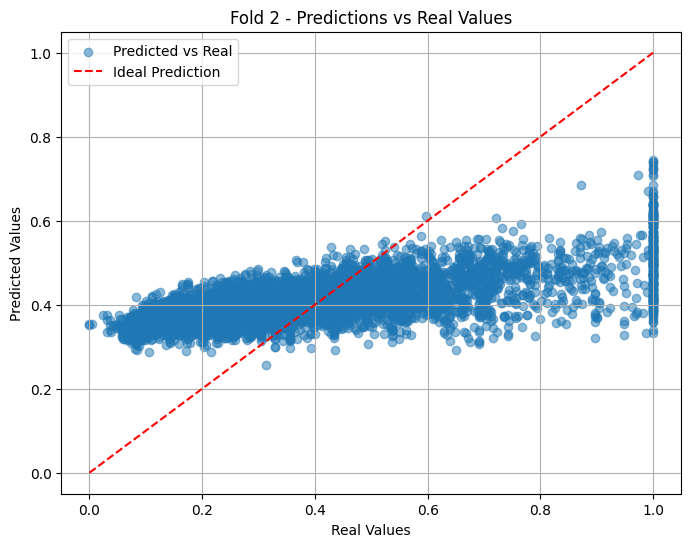

Epoch 1/50, Training Loss: 0.05800327672891406, Validation Loss: 0.056652314991045824
Epoch 2/50, Training Loss: 0.057729663176239635, Validation Loss: 0.05651702091442576
Epoch 3/50, Training Loss: 0.0577645258074306, Validation Loss: 0.05642791414842229
Epoch 4/50, Training Loss: 0.05761632564399229, Validation Loss: 0.05640700806300166
Epoch 5/50, Training Loss: 0.05745153016855903, Validation Loss: 0.056174692453877156
Epoch 6/50, Training Loss: 0.05738538998476705, Validation Loss: 0.05613030744511942
Epoch 7/50, Training Loss: 0.057323645191589785, Validation Loss: 0.05603547838560892
Epoch 8/50, Training Loss: 0.057461256556116655, Validation Loss: 0.056272256024639825
Epoch 9/50, Training Loss: 0.057202663084077204, Validation Loss: 0.05596185257031071
Epoch 10/50, Training Loss: 0.057122575404498006, Validation Loss: 0.05581978465778907
Epoch 11/50, Training Loss: 0.057022029894448704, Validation Loss: 0.05575030687594217
Epoch 12/50, Training Loss: 0.057324454790699586, Valid

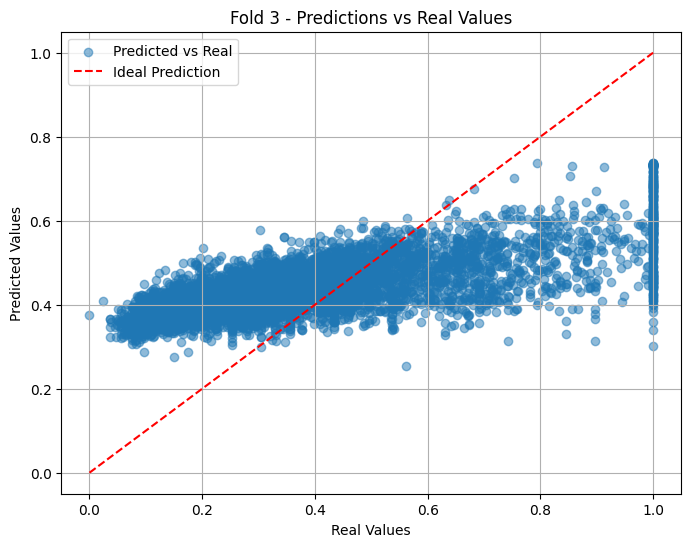

Epoch 1/50, Training Loss: 0.2152083192625305, Validation Loss: 0.21611639040865185
Epoch 2/50, Training Loss: 0.2152083192625305, Validation Loss: 0.21611639040865185
Epoch 3/50, Training Loss: 0.2152083192625305, Validation Loss: 0.21611639040865185
Epoch 4/50, Training Loss: 0.2152083192625305, Validation Loss: 0.21611639040865185
Epoch 5/50, Training Loss: 0.2152083192625305, Validation Loss: 0.21611639040865185
Epoch 6/50, Training Loss: 0.2152083192625305, Validation Loss: 0.21611639040865185
Epoch 7/50, Training Loss: 0.2152083192625305, Validation Loss: 0.21611639040865185
Epoch 8/50, Training Loss: 0.2152083192625305, Validation Loss: 0.21611639040865185
Epoch 9/50, Training Loss: 0.2152083192625305, Validation Loss: 0.21611639040865185
Epoch 10/50, Training Loss: 0.2152083192625305, Validation Loss: 0.21611639040865185
Epoch 11/50, Training Loss: 0.2152083192625305, Validation Loss: 0.21611639040865185
Epoch 12/50, Training Loss: 0.2152083192625305, Validation Loss: 0.2161163

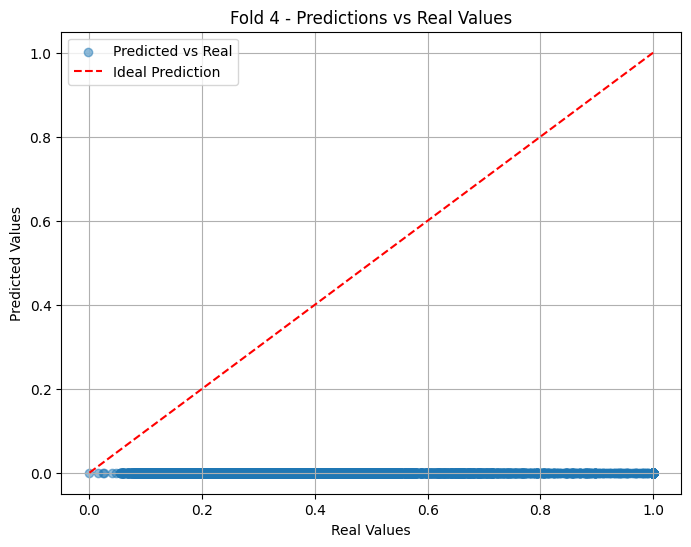

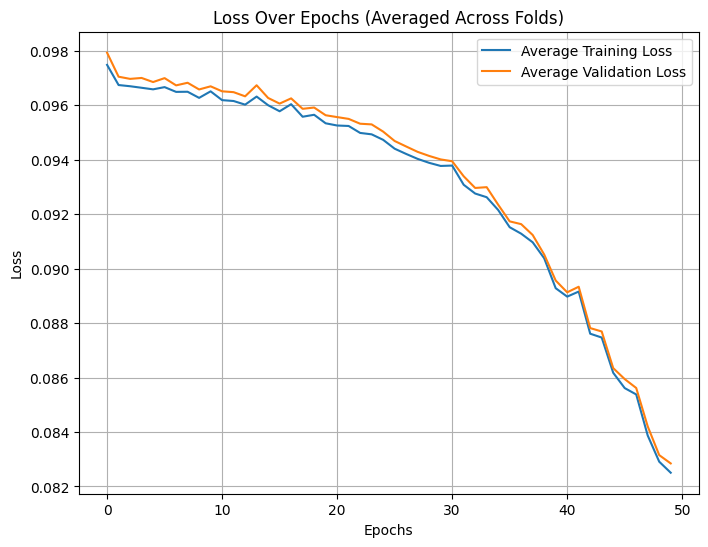

Set 6 Results - MSE: 0.0828, MAE: 0.2170, MAPE: 72.8052
Evaluating Set 7 - Layers: [8, 12, 8, 1], Learning Rate: 0.01, Momentum: 0.8, Activation: tanh
Epoch 1/50, Training Loss: 0.05878825982074224, Validation Loss: 0.06204923975021206
Epoch 2/50, Training Loss: 0.059955139322760975, Validation Loss: 0.06338376313758147
Epoch 3/50, Training Loss: 0.05335940331994247, Validation Loss: 0.055035875710521466
Epoch 4/50, Training Loss: 0.044794038389815945, Validation Loss: 0.04752052390081585
Epoch 5/50, Training Loss: 0.05121202683320009, Validation Loss: 0.05238303892048657
Epoch 6/50, Training Loss: 0.034577582267351845, Validation Loss: 0.03664119097810369
Epoch 7/50, Training Loss: 0.041128636984959895, Validation Loss: 0.04236872625413103
Epoch 8/50, Training Loss: 0.03135210621000256, Validation Loss: 0.033070350447167086
Epoch 9/50, Training Loss: 0.030430597552310933, Validation Loss: 0.03202550217477907
Epoch 10/50, Training Loss: 0.032435086511347654, Validation Loss: 0.03376377

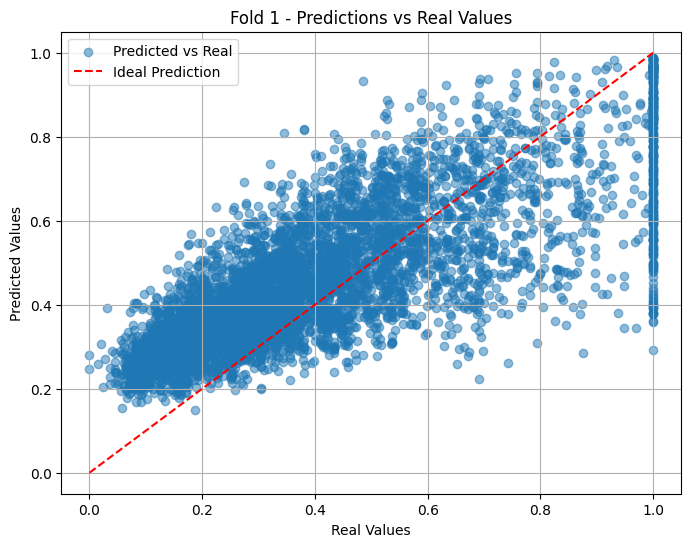

Epoch 1/50, Training Loss: 0.06695786694593432, Validation Loss: 0.06516604478298517
Epoch 2/50, Training Loss: 0.05671642864798137, Validation Loss: 0.055498978100601615
Epoch 3/50, Training Loss: 0.05247641697104059, Validation Loss: 0.051613382976994165
Epoch 4/50, Training Loss: 0.050045144071683575, Validation Loss: 0.04929940086391573
Epoch 5/50, Training Loss: 0.04244552715000684, Validation Loss: 0.042292223590733424
Epoch 6/50, Training Loss: 0.039668688242951486, Validation Loss: 0.03955269849751586
Epoch 7/50, Training Loss: 0.03719631149750436, Validation Loss: 0.03730657489462284
Epoch 8/50, Training Loss: 0.04260675380765413, Validation Loss: 0.04285119813390827
Epoch 9/50, Training Loss: 0.03217365735134246, Validation Loss: 0.032305465384531745
Epoch 10/50, Training Loss: 0.03319134302868012, Validation Loss: 0.03329632365778292
Epoch 11/50, Training Loss: 0.04105567929550533, Validation Loss: 0.04107603489686878
Epoch 12/50, Training Loss: 0.03442351297012534, Validati

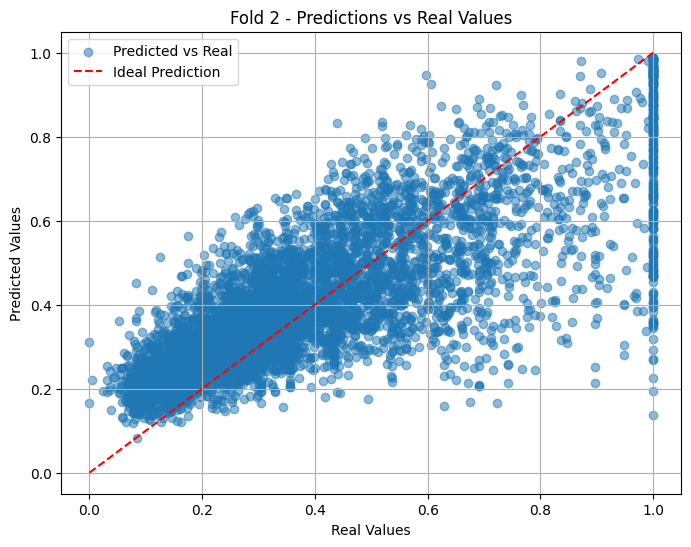

Epoch 1/50, Training Loss: 0.06443381510512444, Validation Loss: 0.06263767121391395
Epoch 2/50, Training Loss: 0.056189380787801946, Validation Loss: 0.055013653242444914
Epoch 3/50, Training Loss: 0.05324250471669435, Validation Loss: 0.051784573876054
Epoch 4/50, Training Loss: 0.05053976816530912, Validation Loss: 0.04864568021135559
Epoch 5/50, Training Loss: 0.042576020007192274, Validation Loss: 0.04087492711817514
Epoch 6/50, Training Loss: 0.03919296335260152, Validation Loss: 0.03721259427062009
Epoch 7/50, Training Loss: 0.03946989247528679, Validation Loss: 0.03813209877456679
Epoch 8/50, Training Loss: 0.03470753185671539, Validation Loss: 0.0327701026473736
Epoch 9/50, Training Loss: 0.03974544748334498, Validation Loss: 0.03862571917369201
Epoch 10/50, Training Loss: 0.05532069685902419, Validation Loss: 0.05462826902362644
Epoch 11/50, Training Loss: 0.041796253219454946, Validation Loss: 0.03934424108493483
Epoch 12/50, Training Loss: 0.07115797976821463, Validation Lo

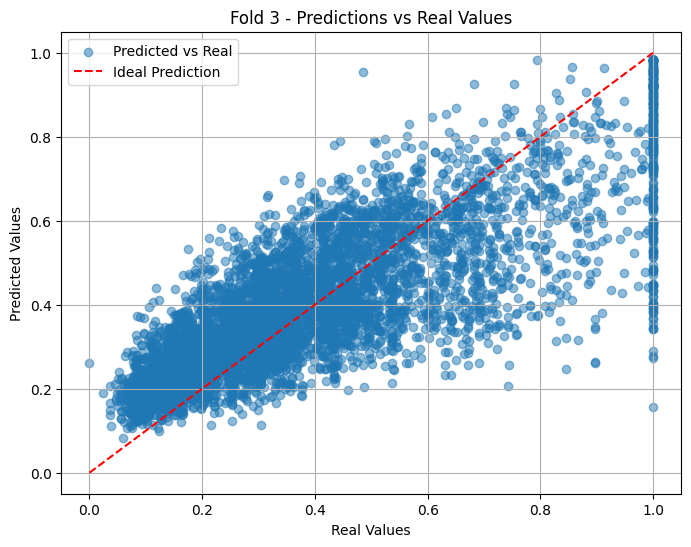

Epoch 1/50, Training Loss: 0.06282214810765474, Validation Loss: 0.062323277037654785
Epoch 2/50, Training Loss: 0.05969387626660447, Validation Loss: 0.059561302741732866
Epoch 3/50, Training Loss: 0.05692646311728667, Validation Loss: 0.0567123216845836
Epoch 4/50, Training Loss: 0.056308966998151154, Validation Loss: 0.05609502706347215
Epoch 5/50, Training Loss: 0.051422273602315674, Validation Loss: 0.050977598334126586
Epoch 6/50, Training Loss: 0.05017298563129443, Validation Loss: 0.049840526247839745
Epoch 7/50, Training Loss: 0.043535002875136466, Validation Loss: 0.04307071594698883
Epoch 8/50, Training Loss: 0.041318967083823266, Validation Loss: 0.04099835784747775
Epoch 9/50, Training Loss: 0.04590063337122648, Validation Loss: 0.04566445963191661
Epoch 10/50, Training Loss: 0.03397160946312708, Validation Loss: 0.03386315357269064
Epoch 11/50, Training Loss: 0.037879669678870596, Validation Loss: 0.037830087957012
Epoch 12/50, Training Loss: 0.03124519171976244, Validati

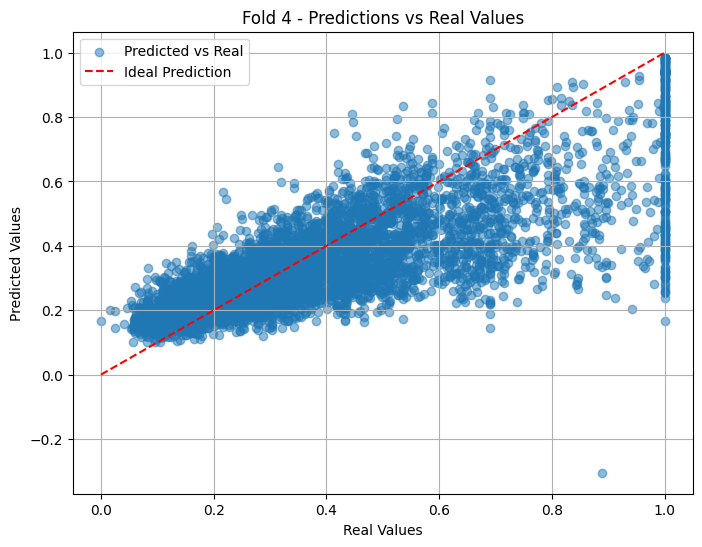

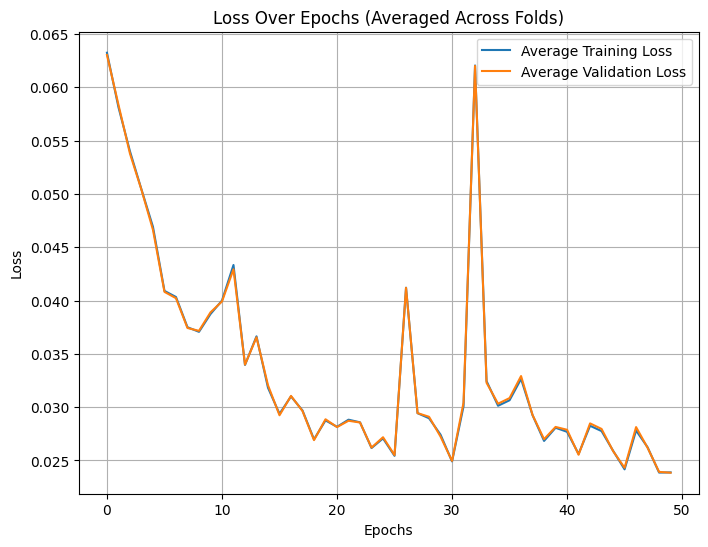

Set 7 Results - MSE: 0.0238, MAE: 0.1159, MAPE: 40.8104
Evaluating Set 8 - Layers: [8, 15, 1], Learning Rate: 0.0001, Momentum: 0.4, Activation: linear
Epoch 1/50, Training Loss: 0.05696435073022799, Validation Loss: 0.05957825208522913
Epoch 2/50, Training Loss: 0.05694131244429537, Validation Loss: 0.05960700421047641
Epoch 3/50, Training Loss: 0.056930121069871546, Validation Loss: 0.059566829278698254
Epoch 4/50, Training Loss: 0.05694279474980179, Validation Loss: 0.05964658844317822
Epoch 5/50, Training Loss: 0.056939150177807096, Validation Loss: 0.05952936041249253
Epoch 6/50, Training Loss: 0.056894359784850766, Validation Loss: 0.05953711265957153
Epoch 7/50, Training Loss: 0.05688294589095029, Validation Loss: 0.05953989528345003
Epoch 8/50, Training Loss: 0.056871734378782214, Validation Loss: 0.05953102799556214
Epoch 9/50, Training Loss: 0.05686215136155337, Validation Loss: 0.059529185485275485
Epoch 10/50, Training Loss: 0.056848273467656696, Validation Loss: 0.05950503

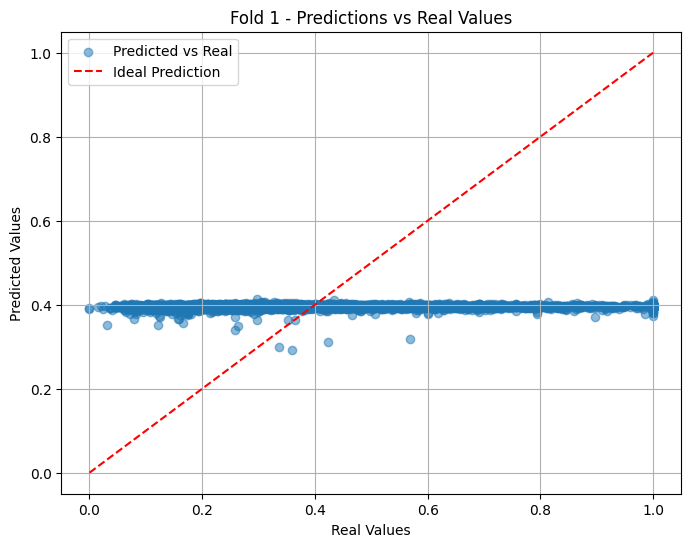

Epoch 1/50, Training Loss: 0.05730205309016957, Validation Loss: 0.05617171478364592
Epoch 2/50, Training Loss: 0.05728668834516418, Validation Loss: 0.05620637202617419
Epoch 3/50, Training Loss: 0.05726774536638169, Validation Loss: 0.0561501970454428
Epoch 4/50, Training Loss: 0.05726117499048542, Validation Loss: 0.056134105255521906
Epoch 5/50, Training Loss: 0.0572750816522083, Validation Loss: 0.05612620823759658
Epoch 6/50, Training Loss: 0.057240771621604486, Validation Loss: 0.05617187581403104
Epoch 7/50, Training Loss: 0.05721353662332125, Validation Loss: 0.056127709804928705
Epoch 8/50, Training Loss: 0.057212700227591465, Validation Loss: 0.05608274142958068
Epoch 9/50, Training Loss: 0.0571856045802856, Validation Loss: 0.0560759912219366
Epoch 10/50, Training Loss: 0.05717626327582756, Validation Loss: 0.0560594227570719
Epoch 11/50, Training Loss: 0.05716075678293266, Validation Loss: 0.05604830035530633
Epoch 12/50, Training Loss: 0.05714390988194793, Validation Loss

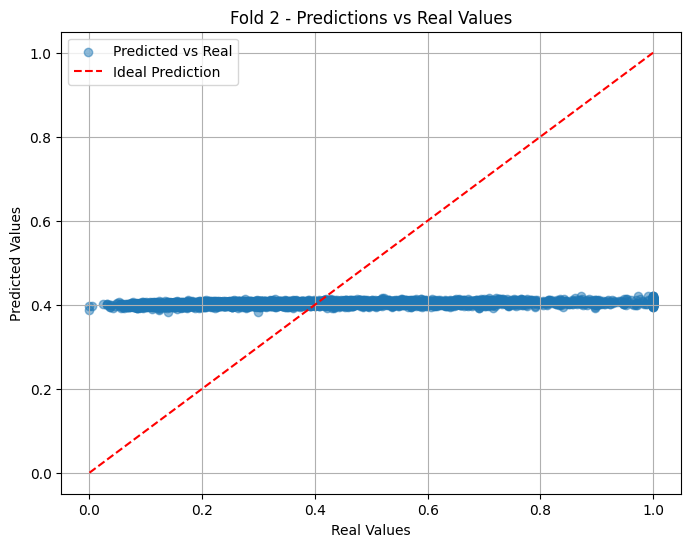

Epoch 1/50, Training Loss: 0.057094595829521436, Validation Loss: 0.05573804860622644
Epoch 2/50, Training Loss: 0.05702486464936109, Validation Loss: 0.055644055985181795
Epoch 3/50, Training Loss: 0.05699024253424028, Validation Loss: 0.055588164248943
Epoch 4/50, Training Loss: 0.05698301524489614, Validation Loss: 0.055593933703049776
Epoch 5/50, Training Loss: 0.05695939395206482, Validation Loss: 0.055559699032152764
Epoch 6/50, Training Loss: 0.05697675461428721, Validation Loss: 0.05560258196546834
Epoch 7/50, Training Loss: 0.05695830705330025, Validation Loss: 0.05551885820449128
Epoch 8/50, Training Loss: 0.056915982006558716, Validation Loss: 0.055520755447038384
Epoch 9/50, Training Loss: 0.05689643029096085, Validation Loss: 0.055480693162221324
Epoch 10/50, Training Loss: 0.056883060775523867, Validation Loss: 0.05546238740064882
Epoch 11/50, Training Loss: 0.056880954669017145, Validation Loss: 0.055447046075424486
Epoch 12/50, Training Loss: 0.05694912089538169, Valida

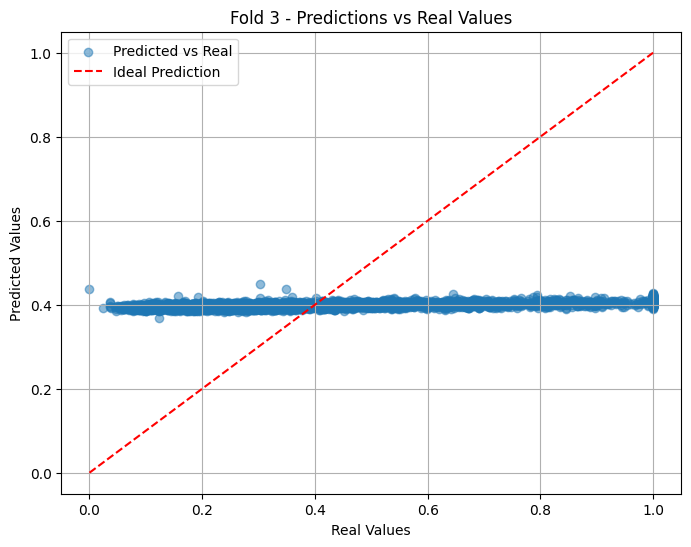

Epoch 1/50, Training Loss: 0.055754580188631574, Validation Loss: 0.05542298389758473
Epoch 2/50, Training Loss: 0.055741785691932944, Validation Loss: 0.05541426796036656
Epoch 3/50, Training Loss: 0.05572194065400007, Validation Loss: 0.05539328428933222
Epoch 4/50, Training Loss: 0.05591019913444289, Validation Loss: 0.05553169927608441
Epoch 5/50, Training Loss: 0.05570648017053104, Validation Loss: 0.05535479586840041
Epoch 6/50, Training Loss: 0.05571604789445446, Validation Loss: 0.05540055061428735
Epoch 7/50, Training Loss: 0.05565986391420887, Validation Loss: 0.05531029407750251
Epoch 8/50, Training Loss: 0.0556276186699827, Validation Loss: 0.05529506124528891
Epoch 9/50, Training Loss: 0.055757207437209716, Validation Loss: 0.055383178348235244
Epoch 10/50, Training Loss: 0.055593493396594675, Validation Loss: 0.055262102805237426
Epoch 11/50, Training Loss: 0.05559057569027495, Validation Loss: 0.055265069736292895
Epoch 12/50, Training Loss: 0.05555060351117023, Validati

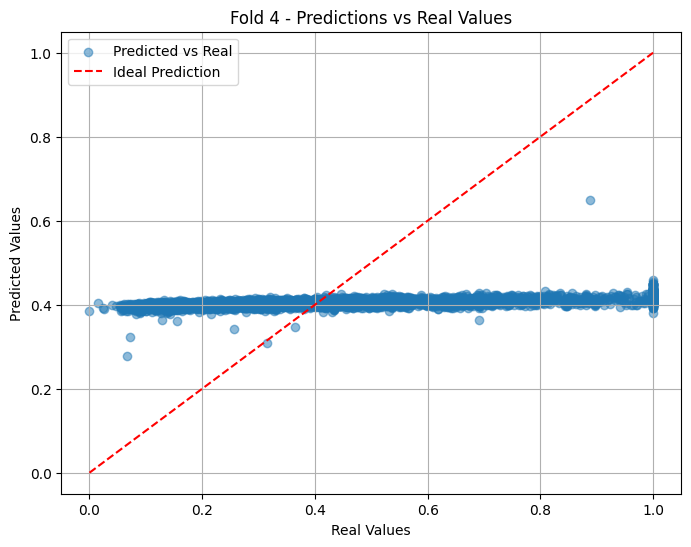

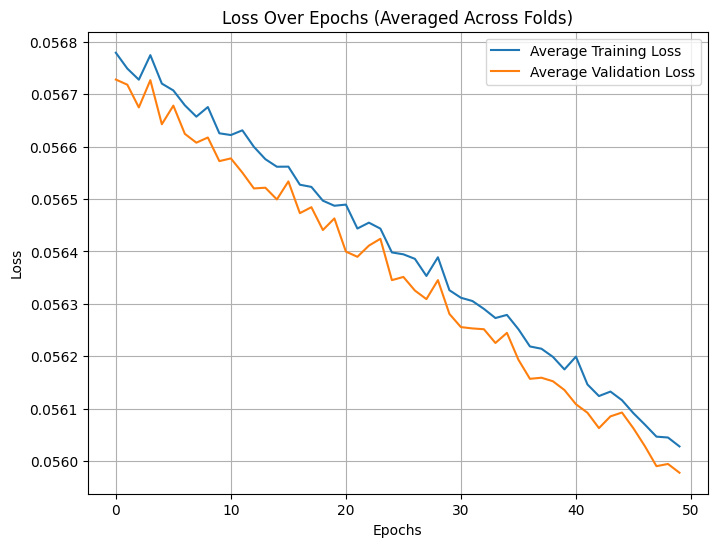

Set 8 Results - MSE: 0.0560, MAE: 0.1878, MAPE: 75.3937
Evaluating Set 9 - Layers: [8, 18, 14, 1], Learning Rate: 0.0001, Momentum: 0.5, Activation: relu
Epoch 1/50, Training Loss: 0.2137425760605977, Validation Loss: 0.22051388316403753
Epoch 2/50, Training Loss: 0.2137425760605977, Validation Loss: 0.22051388316403753
Epoch 3/50, Training Loss: 0.2137425760605977, Validation Loss: 0.22051388316403753
Epoch 4/50, Training Loss: 0.2137425760605977, Validation Loss: 0.22051388316403753
Epoch 5/50, Training Loss: 0.2137425760605977, Validation Loss: 0.22051388316403753
Epoch 6/50, Training Loss: 0.2137425760605977, Validation Loss: 0.22051388316403753
Epoch 7/50, Training Loss: 0.2137425760605977, Validation Loss: 0.22051388316403753
Epoch 8/50, Training Loss: 0.2137425760605977, Validation Loss: 0.22051388316403753
Epoch 9/50, Training Loss: 0.2137425760605977, Validation Loss: 0.22051388316403753
Epoch 10/50, Training Loss: 0.2137425760605977, Validation Loss: 0.22051388316403753
Epoch

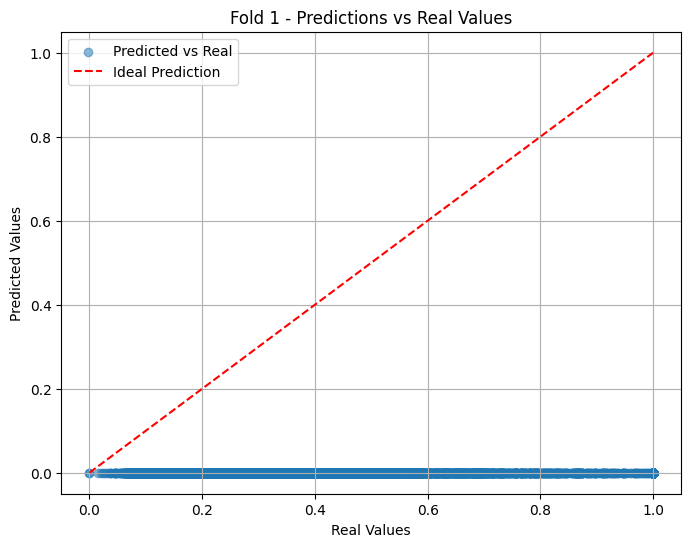

Epoch 1/50, Training Loss: 0.056932780508063566, Validation Loss: 0.05590777689116589
Epoch 2/50, Training Loss: 0.05690373624968997, Validation Loss: 0.05586878072597663
Epoch 3/50, Training Loss: 0.05700604810934159, Validation Loss: 0.056048866085761144
Epoch 4/50, Training Loss: 0.05689918121981009, Validation Loss: 0.055908499380390296
Epoch 5/50, Training Loss: 0.056838186690637796, Validation Loss: 0.05577867799843741
Epoch 6/50, Training Loss: 0.05680701946406068, Validation Loss: 0.055767416516824
Epoch 7/50, Training Loss: 0.05685575061431645, Validation Loss: 0.05575579630162557
Epoch 8/50, Training Loss: 0.0568558372525276, Validation Loss: 0.05589495512251909
Epoch 9/50, Training Loss: 0.0568027347994429, Validation Loss: 0.055708682977651136
Epoch 10/50, Training Loss: 0.05671605450083958, Validation Loss: 0.05569971040281
Epoch 11/50, Training Loss: 0.056691102113563596, Validation Loss: 0.05567675766007096
Epoch 12/50, Training Loss: 0.05671531306015374, Validation Loss

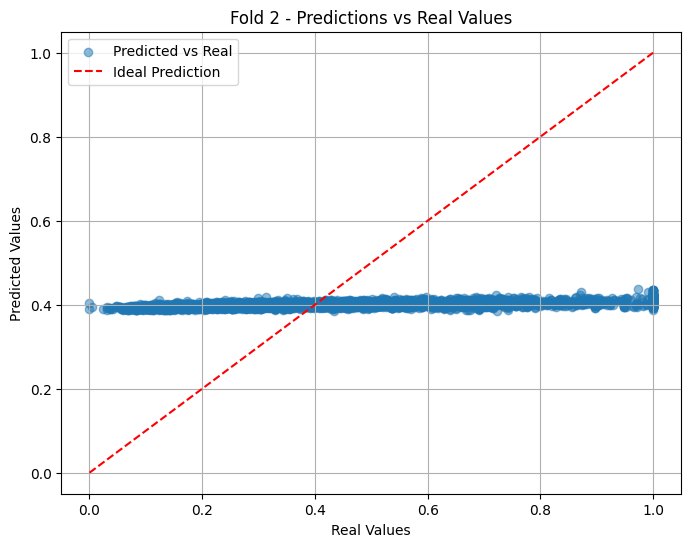

Epoch 1/50, Training Loss: 0.21630391127202583, Validation Loss: 0.21282941768501148
Epoch 2/50, Training Loss: 0.21630391127202583, Validation Loss: 0.21282941768501148
Epoch 3/50, Training Loss: 0.21630391127202583, Validation Loss: 0.21282941768501148
Epoch 4/50, Training Loss: 0.21630391127202583, Validation Loss: 0.21282941768501148
Epoch 5/50, Training Loss: 0.21630391127202583, Validation Loss: 0.21282941768501148
Epoch 6/50, Training Loss: 0.21630391127202583, Validation Loss: 0.21282941768501148
Epoch 7/50, Training Loss: 0.21630391127202583, Validation Loss: 0.21282941768501148
Epoch 8/50, Training Loss: 0.21630391127202583, Validation Loss: 0.21282941768501148
Epoch 9/50, Training Loss: 0.21630391127202583, Validation Loss: 0.21282941768501148
Epoch 10/50, Training Loss: 0.21630391127202583, Validation Loss: 0.21282941768501148
Epoch 11/50, Training Loss: 0.21630391127202583, Validation Loss: 0.21282941768501148
Epoch 12/50, Training Loss: 0.21630391127202583, Validation Los

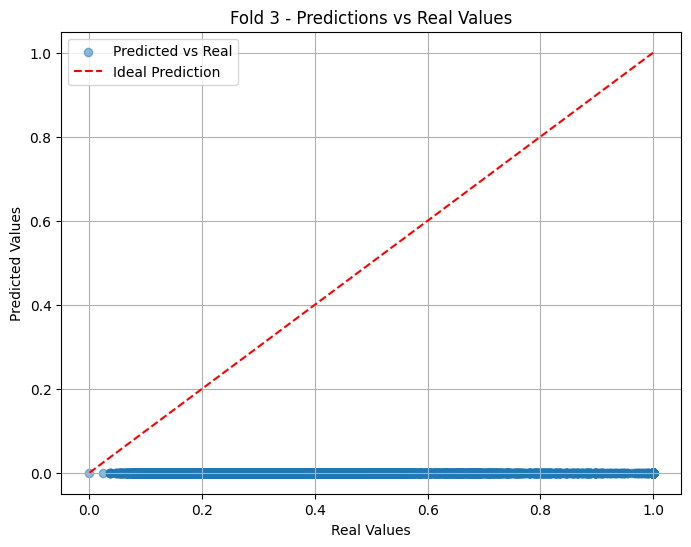

Epoch 1/50, Training Loss: 0.2152083192625305, Validation Loss: 0.21611639040865185
Epoch 2/50, Training Loss: 0.2152083192625305, Validation Loss: 0.21611639040865185
Epoch 3/50, Training Loss: 0.2152083192625305, Validation Loss: 0.21611639040865185
Epoch 4/50, Training Loss: 0.2152083192625305, Validation Loss: 0.21611639040865185
Epoch 5/50, Training Loss: 0.2152083192625305, Validation Loss: 0.21611639040865185
Epoch 6/50, Training Loss: 0.2152083192625305, Validation Loss: 0.21611639040865185
Epoch 7/50, Training Loss: 0.2152083192625305, Validation Loss: 0.21611639040865185
Epoch 8/50, Training Loss: 0.2152083192625305, Validation Loss: 0.21611639040865185
Epoch 9/50, Training Loss: 0.2152083192625305, Validation Loss: 0.21611639040865185
Epoch 10/50, Training Loss: 0.2152083192625305, Validation Loss: 0.21611639040865185
Epoch 11/50, Training Loss: 0.2152083192625305, Validation Loss: 0.21611639040865185
Epoch 12/50, Training Loss: 0.2152083192625305, Validation Loss: 0.2161163

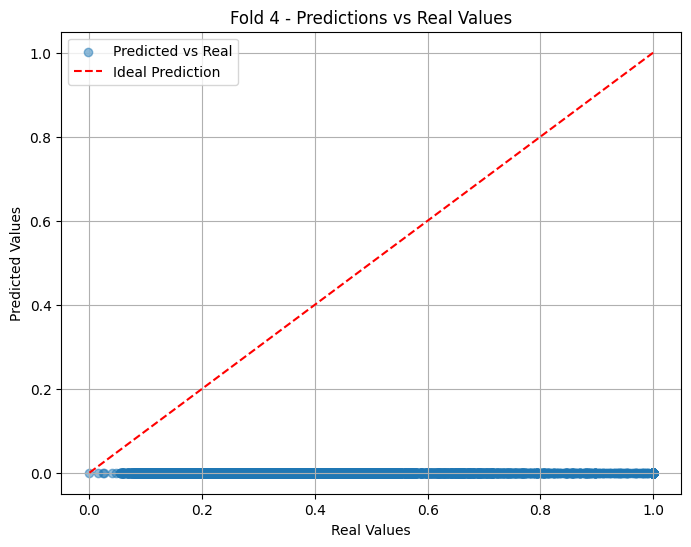

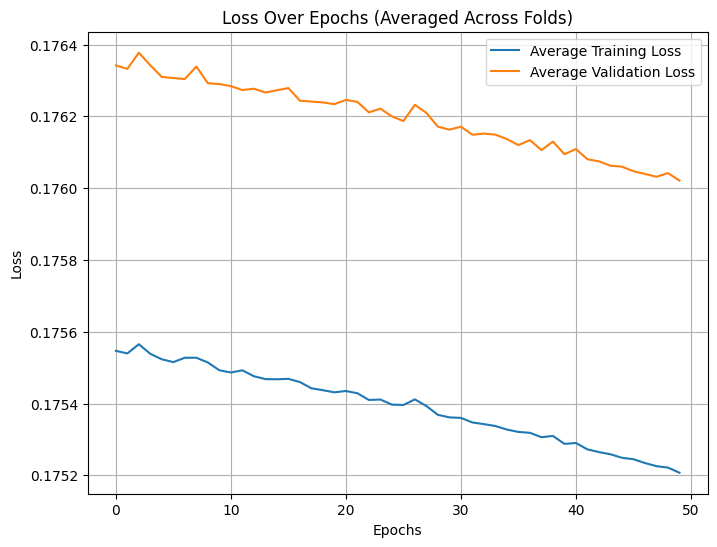

Set 9 Results - MSE: 0.1760, MAE: 0.3457, MAPE: 94.1102
Evaluating Set 10 - Layers: [8, 14, 7, 1], Learning Rate: 1e-05, Momentum: 0.7, Activation: sigmoid
Epoch 1/50, Training Loss: 0.06940200356070206, Validation Loss: 0.07321833210741338
Epoch 2/50, Training Loss: 0.06759825879677905, Validation Loss: 0.07132822597169809
Epoch 3/50, Training Loss: 0.0660025607894827, Validation Loss: 0.06964999011500993
Epoch 4/50, Training Loss: 0.0646123945743659, Validation Loss: 0.06818197880817513
Epoch 5/50, Training Loss: 0.06337696569967742, Validation Loss: 0.06687145569118609
Epoch 6/50, Training Loss: 0.062319890873629484, Validation Loss: 0.06574445998718621
Epoch 7/50, Training Loss: 0.06140665844942338, Validation Loss: 0.06476538359570763
Epoch 8/50, Training Loss: 0.06061120813982952, Validation Loss: 0.06390723798946128
Epoch 9/50, Training Loss: 0.05993179207404712, Validation Loss: 0.06316910477028666
Epoch 10/50, Training Loss: 0.059386077143490514, Validation Loss: 0.06257169048

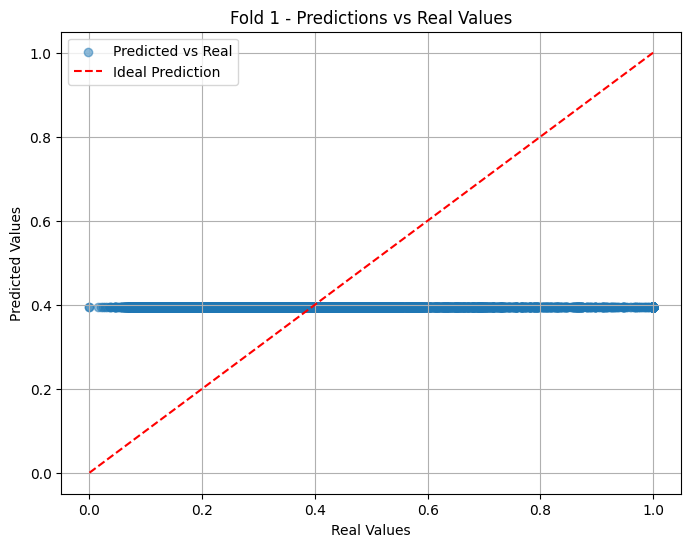

Epoch 1/50, Training Loss: 0.11389838546505703, Validation Loss: 0.11098020012662306
Epoch 2/50, Training Loss: 0.10995816895150333, Validation Loss: 0.10710520272604049
Epoch 3/50, Training Loss: 0.10597028645236128, Validation Loss: 0.1031858789723869
Epoch 4/50, Training Loss: 0.10201466934935165, Validation Loss: 0.09930111902645787
Epoch 5/50, Training Loss: 0.09818337077050929, Validation Loss: 0.09554152670410491
Epoch 6/50, Training Loss: 0.0943487387784844, Validation Loss: 0.0917821392657577
Epoch 7/50, Training Loss: 0.09070269037611085, Validation Loss: 0.08821136909091763
Epoch 8/50, Training Loss: 0.08711647968491433, Validation Loss: 0.08470336280509275
Epoch 9/50, Training Loss: 0.08381936809753925, Validation Loss: 0.0814824602027705
Epoch 10/50, Training Loss: 0.08072962338035285, Validation Loss: 0.07846861147808562
Epoch 11/50, Training Loss: 0.0778356217873317, Validation Loss: 0.07565044267668856
Epoch 12/50, Training Loss: 0.07522841925218463, Validation Loss: 0.

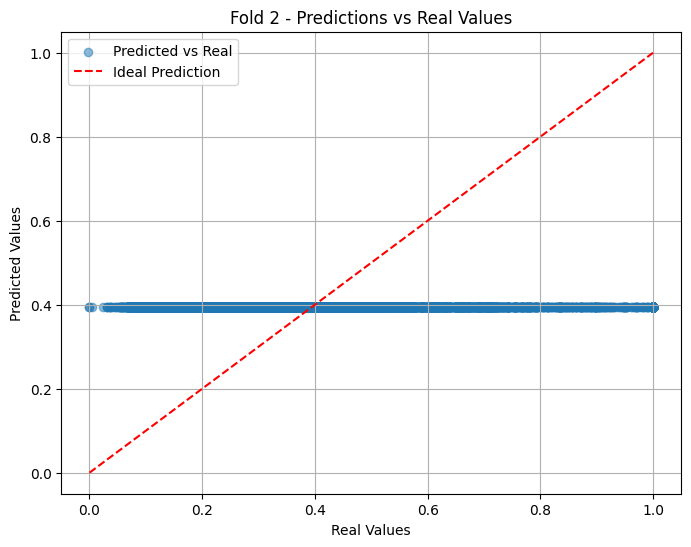

Epoch 1/50, Training Loss: 0.05772108909943644, Validation Loss: 0.056397715887193424
Epoch 2/50, Training Loss: 0.057699687275401444, Validation Loss: 0.05638196583620701
Epoch 3/50, Training Loss: 0.057682234991386507, Validation Loss: 0.05636958847856381
Epoch 4/50, Training Loss: 0.05766079486478401, Validation Loss: 0.056355186900649695
Epoch 5/50, Training Loss: 0.057652551706819925, Validation Loss: 0.05634997467989651
Epoch 6/50, Training Loss: 0.05764382289074831, Validation Loss: 0.05634472550775978
Epoch 7/50, Training Loss: 0.05763645933223622, Validation Loss: 0.05634057536045439
Epoch 8/50, Training Loss: 0.0576292476486899, Validation Loss: 0.05633683988746032
Epoch 9/50, Training Loss: 0.057622124832201777, Validation Loss: 0.05633359650477975
Epoch 10/50, Training Loss: 0.057619980178281294, Validation Loss: 0.056332736981063045
Epoch 11/50, Training Loss: 0.05761566380508316, Validation Loss: 0.05633123108541619
Epoch 12/50, Training Loss: 0.05761278799725122, Validat

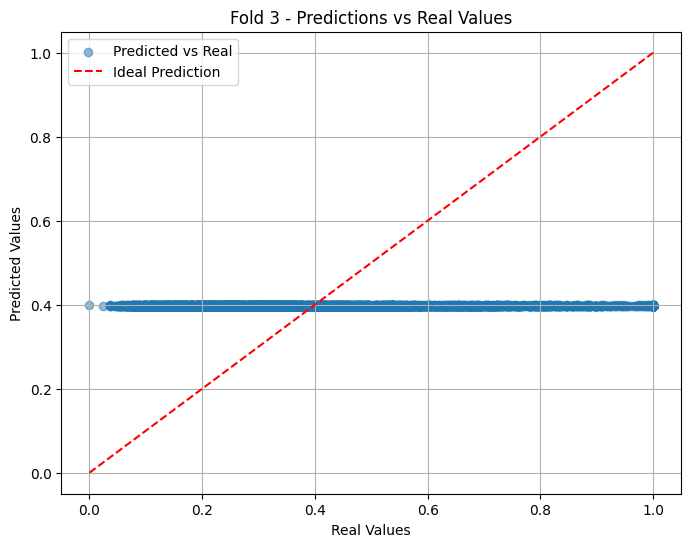

Epoch 1/50, Training Loss: 0.07942404101222189, Validation Loss: 0.07872903903508606
Epoch 2/50, Training Loss: 0.07381004380686189, Validation Loss: 0.07317465701970849
Epoch 3/50, Training Loss: 0.06956716525328699, Validation Loss: 0.06898401124619
Epoch 4/50, Training Loss: 0.06650136355084875, Validation Loss: 0.0659619259288108
Epoch 5/50, Training Loss: 0.06420858587440181, Validation Loss: 0.06370691951444414
Epoch 6/50, Training Loss: 0.06251291956453113, Validation Loss: 0.06204348889920754
Epoch 7/50, Training Loss: 0.061207023542928785, Validation Loss: 0.060766258615857376
Epoch 8/50, Training Loss: 0.0602133901367425, Validation Loss: 0.05979789869155402
Epoch 9/50, Training Loss: 0.05952980369105691, Validation Loss: 0.059134376655613094
Epoch 10/50, Training Loss: 0.05898699834798671, Validation Loss: 0.058609891799430894
Epoch 11/50, Training Loss: 0.0585901255716579, Validation Loss: 0.05822844750690329
Epoch 12/50, Training Loss: 0.05829285406031308, Validation Loss:

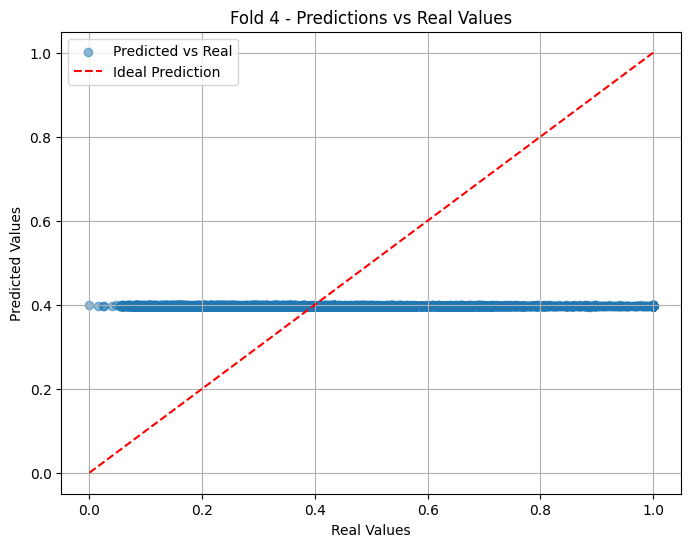

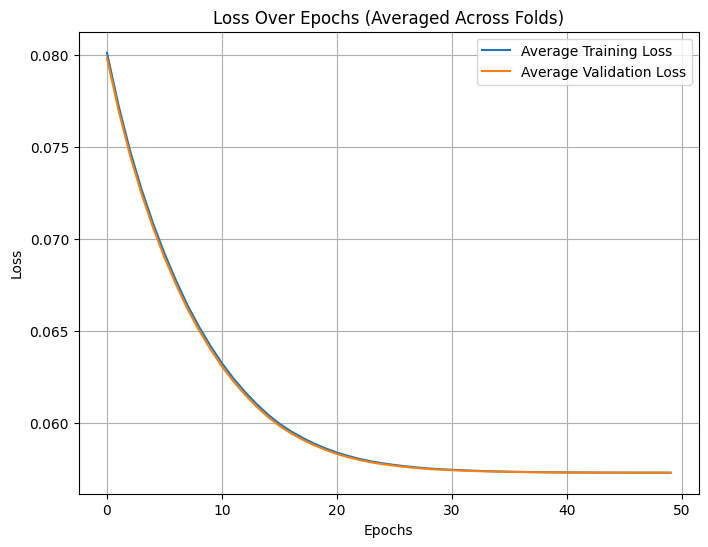

Set 10 Results - MSE: 0.0573, MAE: 0.1894, MAPE: 75.5302
   Set       MSE       MAE       MAPE
0    7  0.023843  0.115912  40.810357
1    3  0.025323  0.115248  36.930089
2    8  0.055978  0.187758  75.393667
3    1  0.057252  0.189508  75.760730
4   10  0.057293  0.189376  75.530234
5    5  0.057431  0.191269  77.822132
6    6  0.082847  0.217048  72.805184
7    2  0.168550  0.335967  91.339960
8    4  0.175373  0.347473  96.320833
9    9  0.176021  0.345705  94.110166
Best Hyperparameter Set: Set      7.000000
MSE      0.023843
MAE      0.115912
MAPE    40.810357
Name: 0, dtype: float64


In [4]:
# Function to calculate MAPE without masking
def mean_absolute_percentage_error(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    # Create a mask to exclude zero or near-zero values in y_true
    mask = y_true > 1e-10
    y_true_masked = y_true[mask]
    y_pred_masked = y_pred[mask]
    
    # Calculate MAPE only for valid values
    return np.mean(np.abs((y_true_masked - y_pred_masked) / y_true_masked)) * 100


# Function to normalize metrics (for fair comparison)
def normalize_metric(metric_values):
    return (metric_values - np.min(metric_values)) / (np.max(metric_values) - np.min(metric_values))

# Function to evaluate the neural network with given hyperparameters using cross-validation
def evaluate_model_with_cross_validation(layers, epochs, learning_rate, momentum, activation, k_folds=4):
    """
    Perform k-fold cross-validation and return average validation metrics and plots.
    """
    fold_size = len(X_train_scaled) // k_folds  # Determine the size of each fold
    metrics_list = []  # To store metrics for each fold
    overall_train_loss, overall_val_loss = [], []  # To store loss curves across folds

    for fold in range(k_folds):
        # Split data into training and validation subsets
        start, end = fold * fold_size, (fold + 1) * fold_size
        X_val_fold, y_val_fold = X_train_scaled[start:end], y_train[start:end]
        X_train_fold = np.concatenate([X_train_scaled[:start], X_train_scaled[end:]])
        y_train_fold = np.concatenate([y_train[:start], y_train[end:]])

        # Initialize the neural network
        nn_model = NeuralNet(
            layers=layers,
            epochs=epochs,
            learning_rate=learning_rate,
            momentum=momentum,
            activation=activation
        )
        
        # Train the model
        train_loss, val_loss = nn_model.fit(X_train_fold, y_train_fold, X_val_fold, y_val_fold)
        overall_train_loss.append(train_loss)
        overall_val_loss.append(val_loss)
        
        # Predict on validation fold
        predictions_fold = nn_model.predict(X_val_fold)
        
        # Calculate evaluation metrics
        mse = mean_squared_error(y_val_fold, predictions_fold)
        mae = mean_absolute_error(y_val_fold, predictions_fold)
        mape = mean_absolute_percentage_error(y_val_fold, predictions_fold)

        # Store metrics for this fold
        metrics_list.append((mse, mae, mape))

        # Scatter Plot: Predicted vs Real Values for this fold
        plt.figure(figsize=(8, 6))
        plt.scatter(y_val_fold, predictions_fold, alpha=0.5, label="Predicted vs Real")
        plt.plot(
            [y_val_fold.min(), y_val_fold.max()], 
            [y_val_fold.min(), y_val_fold.max()], 
            color="red", linestyle="--", label="Ideal Prediction"
        )
        plt.title(f"Fold {fold + 1} - Predictions vs Real Values")
        plt.xlabel("Real Values")
        plt.ylabel("Predicted Values")
        plt.legend()
        plt.grid(True)
        plt.show()
    
    # Plot average loss curves
    avg_train_loss = np.mean(overall_train_loss, axis=0)
    avg_val_loss = np.mean(overall_val_loss, axis=0)
    plt.figure(figsize=(8, 6))
    plt.plot(avg_train_loss, label="Average Training Loss")
    plt.plot(avg_val_loss, label="Average Validation Loss")
    plt.title(f"Loss Over Epochs (Averaged Across Folds)")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Calculate average metrics across all folds
    avg_metrics = np.mean(metrics_list, axis=0)
    return avg_metrics

# List of hyperparameter sets
hyperparameter_sets = [
    {"layers": [8, 9, 1], "epochs": 50, "learning_rate": 0.0001, "momentum": 0.5, "activation": "sigmoid"},
    {"layers": [8, 12, 1], "epochs": 50, "learning_rate": 0.01, "momentum": 0.9, "activation": "relu"},
    {"layers": [8, 10, 5, 1], "epochs": 50, "learning_rate": 0.01, "momentum": 0.9, "activation": "tanh"},
    {"layers": [8, 16, 8, 1], "epochs": 50, "learning_rate": 0.01, "momentum": 0.9, "activation": "relu"},
    {"layers": [8, 8, 8, 1], "epochs": 50, "learning_rate": 0.00001, "momentum": 0.6, "activation": "sigmoid"},
    {"layers": [8, 20, 15, 1], "epochs": 50, "learning_rate": 0.001, "momentum": 0.3, "activation": "relu"},
    {"layers": [8, 12, 8, 1], "epochs": 50, "learning_rate": 0.01, "momentum": 0.8, "activation": "tanh"},
    {"layers": [8, 15, 1], "epochs": 50, "learning_rate": 0.0001, "momentum": 0.4, "activation": "linear"},
    {"layers": [8, 18, 14, 1], "epochs": 50, "learning_rate": 0.0001, "momentum": 0.5, "activation": "relu"},
    {"layers": [8, 14, 7, 1], "epochs": 50, "learning_rate": 0.00001, "momentum": 0.7, "activation": "sigmoid"}
]

# Store results for hyperparameter sets
results = []

# Evaluate all hyperparameter sets using cross-validation
for i, params in enumerate(hyperparameter_sets, start=1):
    print(f"Evaluating Set {i} - Layers: {params['layers']}, Learning Rate: {params['learning_rate']}, Momentum: {params['momentum']}, Activation: {params['activation']}")

    # Evaluate the model with cross-validation
    mse, mae, mape = evaluate_model_with_cross_validation(
        params["layers"],
        params["epochs"],
        params["learning_rate"],
        params["momentum"],
        params["activation"]
    )

    # Append results for comparison
    results.append({"Set": i, "MSE": mse, "MAE": mae, "MAPE": mape})

    # Print Results
    print(f"Set {i} Results - MSE: {mse:.4f}, MAE: {mae:.4f}, MAPE: {mape:.4f}")

# Convert results into a DataFrame
results_df = pd.DataFrame(results)

# Sort by MSE (lower is better)
results_df = results_df.sort_values("MSE").reset_index(drop=True)

# Print results
print(results_df)

# Save results to a CSV file for analysis
results_df.to_csv("hyperparameter_results_sorted_by_mse.csv", index=False)

# Highlight the best-performing hyperparameter set based on the lowest MSE
best_set = results_df.loc[results_df["MSE"].idxmin()]
print(f"Best Hyperparameter Set: {best_set}")


PArt 3-2:

In [5]:
#Part 3.2: Model result comparison
!pip install tensorflow



[notice] A new release of pip is available: 24.1.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [12]:
# Part 3.2: Comparison with Pre-existing Models
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
import matplotlib.pyplot as plt


Best Hyperparameters from Part 3.1: {'layers': [8, 12, 8, 1], 'epochs': 50, 'learning_rate': 0.01, 'momentum': 0.8, 'activation': 'tanh'}
Best Metrics from Part 3.1: {'MSE': 0.023843324312357743, 'MAE': 0.11591224824518499, 'MAPE': 40.81035726796246}
Evaluating Multi-Linear Regression (MLR-F)...
MLR-F Results After Adjustment - MSE: 0.0226, MAE: 0.1076, MAPE: 34.4014
Evaluating Pre-Built Neural Network (BP-F)...
BP-F Results - MSE: 0.0177, MAE: 0.0969, MAPE: 31.5185

Comparison of Models:
              Model       MSE       MAE       MAPE
0  Custom NN (Best)  0.023843  0.115912  40.810357
1             MLR-F  0.022577  0.107607  34.401442
2              BP-F  0.017746  0.096929  31.518483


ValueError: x and y must be the same size

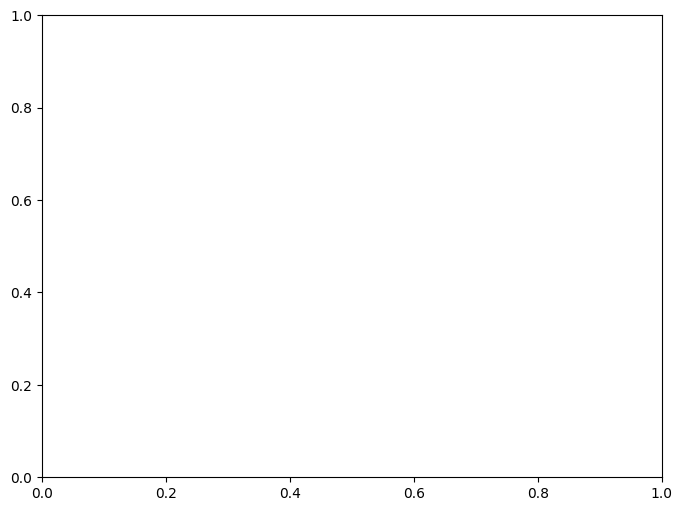

In [ ]:
# Part 3.2: Model Result Comparison

# Extract the best result from Part 3.1
best_set = results_df.loc[results_df["MSE"].idxmin()]
best_hyperparameters = hyperparameter_sets[int(best_set["Set"]) - 1]
best_result = {
    "hyperparameters": best_hyperparameters,
    "metrics": {
        "MSE": best_set["MSE"],
        "MAE": best_set["MAE"],
        "MAPE": best_set["MAPE"]
    }
}
print("Best Hyperparameters from Part 3.1:", best_result["hyperparameters"])
print("Best Metrics from Part 3.1:", best_result["metrics"])

# Use best metrics directly from Part 3.1
mse_nn = best_result["metrics"]["MSE"]
mae_nn = best_result["metrics"]["MAE"]
mape_nn = best_result["metrics"]["MAPE"]

# --- Evaluate Multi-Linear Regression (MLR-F) ---
print("Evaluating Multi-Linear Regression (MLR-F)...")

# Feature Scaling
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Log Transformation for Target
import numpy as np
y_train_log = np.log1p(y_train)  # Apply log transformation
y_val_log = np.log1p(y_val)

# Train MLR-F on Transformed Target
mlr_model = LinearRegression()
mlr_model.fit(X_train_scaled, y_train_log)
mlr_predictions_log = mlr_model.predict(X_val_scaled)

# Reverse Log Transformation for Predictions
mlr_predictions = np.expm1(mlr_predictions_log)

# Calculate Metrics for MLR-F
mse_mlr = mean_squared_error(y_val, mlr_predictions)
mae_mlr = mean_absolute_error(y_val, mlr_predictions)

# Adjusted MAPE (Excluding Near-Zero Values)
def adjusted_mape(y_true, y_pred):
    mask = y_true > 1e-10
    y_true, y_pred = y_true[mask], y_pred[mask]
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape_mlr = adjusted_mape(y_val, mlr_predictions)
print(f"MLR-F Results After Adjustment - MSE: {mse_mlr:.4f}, MAE: {mae_mlr:.4f}, MAPE: {mape_mlr:.4f}")

# --- Evaluate Pre-Built Neural Network (BP-F) ---
print("Evaluating Pre-Built Neural Network (BP-F)...")
bp_model = MLPRegressor(
    hidden_layer_sizes=best_hyperparameters["layers"][1:-1],  # Exclude input/output layers
    max_iter=200,
    random_state=42,
    activation="relu"  # Using ReLU for BP-F
)
bp_model.fit(X_train_scaled, y_train.ravel())
bp_predictions = bp_model.predict(X_val_scaled)

# Metrics for BP-F
mse_bp = mean_squared_error(y_val, bp_predictions)
mae_bp = mean_absolute_error(y_val, bp_predictions)
mape_bp = mean_absolute_percentage_error(y_val.ravel(), bp_predictions.ravel())
print(f"BP-F Results - MSE: {mse_bp:.4f}, MAE: {mae_bp:.4f}, MAPE: {mape_bp:.4f}")

# --- Create Comparison Table ---
comparison_df = pd.DataFrame({
    "Model": ["Custom NN (Best)", "MLR-F", "BP-F"],
    "MSE": [mse_nn, mse_mlr, mse_bp],
    "MAE": [mae_nn, mae_mlr, mae_bp],
    "MAPE": [mape_nn, mape_mlr, mape_bp]
})

print("\nComparison of Models:")
print(comparison_df)

# Scatter Plot for Predictions vs Actual Values (MLR-F and BP-F)
plt.figure(figsize=(8, 6))
plt.scatter(y_val, mlr_predictions, alpha=0.6, label="MLR-F", color="green")
plt.scatter(y_val, bp_predictions, alpha=0.6, label="BP-F", color="blue")
plt.plot(
    [y_val.min(), y_val.max()],
    [y_val.min(), y_val.max()],
    color="red",
    linestyle="--",
    label="Ideal Prediction"
)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Predicted vs Actual Values (MLR-F and BP-F)")
plt.legend()
plt.grid(True)
plt.show()
